# 1-D INTERNAL STRUCTURE MODELS FOR PLANETS<br>USING NEW ANEOS MATERIAL MODELS
<b>Forsterite-ANEOS-SLVTv1.0G1<br>
Iron-ANEOS-SLVTv0.2G1<br>
Fe85Si15-ANEOS-SLVTv0.2G1</b><p>

This notebook is used to document the initial conditions for model planets in SPH. 

S.T. Stewart ([sts@ucdavis.edu](mailto:sts@ucdavis.edu))<br>
Philip J. Carter<br>
Adriana N. Postema ([anpostema@ucdavis.edu](mailto:anpostema@ucdavis.edu))

## Instructions:
This notebook builds planets for SWIFT initialization from isentropic temperature-pressure profiles specified by the user. 

To generate a single planet or set of target-impactor planets, start at the cell labeled "Main Cell". You can control the thermal profile by either specifying one of the built-in wildcard settings (see the cell for more information), specifying a mantle or core potential temperature, or by manually selecting an isentrope for the mantle and core material. The notebook will then create a text file containing the P-T points in the chosen planet profile, an hdf5 file containing the initial SPH conditions for a SWIFT relaxation simulation run, and an output text file containing the metadata and parameters chosen for that planet. 

This notebook can also take an existing thermal profile from a text file and (if properly formatted) can generate an SPH initial conditions file.

There is also an option to perform bulk operations of these jobs that intakes a list of specifications and outputs a list of planets. 

This notebook also contains plotting code to visually check the P-T profiles of the resulting planets and to confirm the agreement of the SPH particles and analytic profile.

### For relaxation:
Use the output planet hdf5 files as initial conditions for SWIFT relaxation simulations. Compile SWIFT using --enable-planetary-fixed-entropy and then simply use the hdf5 files as standard initial condition files — no need to specify fixed entropy values in the parameter file like Gadget2. To replicate our relaxation routines, use the SWIFT fork of the planetary_plus_subtask_speedup branch in the PlanetSim github group repository. The hacks that enable velocity damping, removal of viscous heating, and extra entropy forcing will all turn on when compiling with fixed entropy and the standard planetary hydro scheme (and will remain off when compiling normally).

After relaxation, use the thermal profiles (output as a .txt file from this notebook) and the final SWIFT snapshot from your initialization runs as inputs for the SWIFT_Orientation notebook. 

In [2]:
# this cell has a java script that that enables hiding the raw python code

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Prerequisite cells: setting up functions

In [1]:
# Record the verions information for these calculation for posterity
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy

import sys

import woma
import seagen
#print('seagen version: ', seagen.__version__)
import gadget_sph
from importlib import reload
#reload(gadget)

from woma.misc import glob_vars as gv
from woma.eos import sesame
from woma.eos.T_rho import T_rho
from woma.misc import utils, io

# First we import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import colormaps as local_cmaps
import os
from copy import deepcopy
from pathlib import Path
import pkgutil
import h5py

%run eostable.py

%config InlineBackend.figure_format = 'retina'

plt.rcParams["figure.figsize"] = (20,10) # default figure size in inches

#eospath = os.path.expanduser('~') + '/Work/'
eospath = '../'

python version:  3.9.7
matplotlib version:  3.8.3
numpy version:  1.23.1
scipy version:  1.12.0


In [2]:
# Declare some standard variables
G_mks = 6.67E-11 # Gravitational constant  m3/kg/s2
##Mearth = 5.972E24 # Earth's mass kg
R_earth = 6371.E3  # Earth's radius m
##Rcmb = 3480000. # CMB radius in m (from PREM)

G = 6.67E-8 # Gravitational constant  cm3/g/s2
Mearth = 5.972E27 # Earth's mass g
Rearth = 6371.E5  # Earth's radius cm
Rcmb = 348000000. # CMB radius in cm (from PREM)

In [3]:
def pdt_solidus(P=None,T=None):
    pdt_arr=np.array([[0.0, 1706.3],
             [0.1, 1706.319],
             [2.3522, 1706.3197],
             [2.7285, 1780.6691],
             [3.4812, 1862.9846],
             [4.2339, 1939.9893],
             [5.1747, 2009.0281],
             [6.3038, 2088.6883],
             [7.621, 2157.7269],
             [9.0323, 2221.4551],
             [10.7258, 2269.2511],
             [12.9839, 2303.7706],
             [15.1478, 2322.3578],
             [16.1828, 2364.8433],
             [17.1237, 2402.0181],
             [18.1586, 2407.3287],
             [19.8521, 2409.9841],
             [21.5457, 2417.9501],
             [22.7688, 2441.8481],
             [23.8978, 2473.7122],
             [30.9543, 2648.9644],
             [35.0941, 2747.2119],
             [39.422, 2853.4254],
             [43.2796, 2941.0515],
             [46.1962, 3010.0903],
             [49.5833, 3079.129],
             [54.7581, 3187.9979],
             [58.0511, 3251.726],
             [64.2608, 3368.5608],
             [70.0941, 3474.7743],
             [77.8091, 3596.9198],
             [85.7124, 3719.0653],
             [91.6398, 3798.7254],
             [98.2258, 3878.3856],
             [105.0941, 3950.0796],
             [112.1505, 4021.7738],
             [118.7366, 4069.5697],
             [126.3575, 4125.3319],
             [131.9085, 4154.5406],
             [140.0, 4194.3707],
             [240.0, 4686.6168]])
    pdtsolidusPT=interpolate.interp1d(pdt_arr[:,0],pdt_arr[:,1])
    pdtsolidusTP=interpolate.interp1d(pdt_arr[:,1],pdt_arr[:,0])
    if P is not None:
        return pdtsolidusPT(P) #return temperature
    if T is not None:
        return pdtsolidusTP(T) #return pressure (in GPa)
    
solvusfn = interpolate.interp1d([0,50.e9,100.e9,400.e9,1000.e9],[4080,6094,6752,9337,14507.0])

## Gather datasets

<b>PREM</b>
PREM is a one-dimensional average structure model for the Earth developed from seismic data. The original reference is:<br>
<b>Dziewonski, A. M., and D. L. Anderson. 1981. "Preliminary reference Earth model." Phys. Earth Plan. Int. 25:297-356.</b>

The 1D model has been updated by Panning and Romanowicz (2006). Download the Modified PREM model from the <a href="http://ds.iris.edu/spud/earthmodel/9785674">IRIS web site</a>.


In [4]:
if __name__!="__main__":
    datadir = os.path.join( os.path.dirname(__file__) , './data/')
else:
    datadir='../makeplanets/data/'

#Durek, J. J., and G. Ekstrom (1996) Modified PREM (Preliminary Reference Earth Model), doi:10.17611/DP/9785674, http://ds.iris.edu/spud/earthmodel/9785674.
# Read in PREM: Preliminary Earth Reference Model
PREM_filename=datadir+'PREM500_IDV.csv' # we love long, readable variable names!

print(PREM_filename)

# make a class to hold the PREM data
class PREMclass:
    """Class to hold PREM data and other 1-D Earth variables."""  # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.NR = 0 # number of radius points
        self.radius = np.zeros(self.NR) 
        self.density = np.zeros(self.NR)   
        self.pwavevel = np.zeros(self.NR)   
        self.swavevel = np.zeros(self.NR)
        self.pressure = np.zeros(self.NR)
        self.temperature = np.zeros(self.NR)
        # not going to use all the variables in the file
        self.units = '' # I like to keep a text note in a structure about the units

# initialize an empty PREM object
PREM = PREMclass()

# read the data into the class parameters
PREM.radius = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[0]) # radius in m
PREM.density = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[1]) # density in kg/m3
PREM.pwavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[2]) # p-wave velocity m/s
PREM.swavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[3]) # s-wave velocity m/s
PREM.NR = len(PREM.radius) # number of radius points
PREM.units = 'radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s)'

# start at the surface and integrate via a for loop to the center of the planet

# calculate the thickness of each layer in the PREM model using the roll function
PREM_dr = np.roll(PREM.radius,-1)-PREM.radius 
PREM_dr[PREM.NR-1] = 0. # we are not using the last entry in the list because there are NR-1 layers
#print(PREM_dr)

# calculate the mass of each layer
# density x area x thickness of each layer
PREM_mass_rad = PREM.density*(4.*np.pi*PREM.radius*PREM.radius*PREM_dr) 

# core radius
ir0 = np.where(PREM.density < 6000.)[0]
PREM_rcore = PREM.radius[ir0[0]]
  

PREM.pressure = np.zeros(PREM.NR) # make array of zeros for pressure of the same length as the arrays in the PREM model
# The first entry is the middle of the planet, so start at the surface and integrate inwards
for i in range(PREM.NR-2,0,-1):
    # we indent for the code in the for loop
    PREM.pressure[i] = PREM.pressure[i+1]+G_mks*np.sum(PREM_mass_rad[0:i-1])*PREM.density[i]*PREM_dr[i]/PREM.radius[i]/PREM.radius[i]

PREM_mass_enclosed = np.zeros(PREM.NR) # make a new array
for i in range(1,PREM.NR):
    PREM_mass_enclosed[i] = np.sum(PREM_mass_rad[0:i])

# use SESAME units
PREM.pressure = PREM.pressure/1.E9 # GPa

# Check that the total mass is the mass of the Earth
print('PREM total mass (kg)=',np.sum(PREM_mass_rad))
print('PREM total mass (Mearth)=',np.sum(PREM_mass_rad)/5.972E24)
print("PREM core radius (km)=",PREM_rcore/1.e3)
print("PREM core mass fraction=",PREM_mass_enclosed[ir0[0]]/np.sum(PREM_mass_rad))
print("PREM central pressure (GPa)=",PREM.pressure[1])

  

# read in the temperature vs pressure profile from the Anzellini et al. plot
#Anzellini, S., Dewaele, A., Mezouar, M., Loubeyre, P., & Morard, G. (2013). Melting of iron at Earth’s inner core boundary based on fast X-ray diffraction. Science, 340(6131), 464-466.
Anzellini_filename = datadir+'Anzellini-2013-Science-coretemp.csv'
Anzellini_pressure  = np.loadtxt(Anzellini_filename,delimiter=',',skiprows=0,usecols=[0]) # GPa
Anzellini_temperature  = np.loadtxt(Anzellini_filename,delimiter=',',skiprows=0,usecols=[1]) # K
# we want to use this data with PREM but it doesn't have the same number of points
# interpolate the Anzellini profile to match the PREM profile
# the following defines a function = y(x)
interp_func = interpolate.interp1d(Anzellini_pressure,Anzellini_temperature,fill_value="extrapolate") 
PREM.temperature = interp_func(PREM.pressure) # ynew = function(xnew) provides the interpolated ynew at each xnew

#Fiquet, G., Auzende, A. L., Siebert, J., Corgne, A., Bureau, H., Ozawa, H., & Garbarino, G. (2010). Melting of peridotite to 140 gigapascals. Science, 329(5998), 1516-1518.
# Fiquet et al 2010 Peridotite solidus and liquidus
# P GPa, T K
peridotitefile = open(datadir+"Fiquet-2010-Science-Peridotite-Melting-Fig3-solidus.txt","r")  
peridotitesolidusdatarr = pd.read_csv(peridotitefile,skiprows=1)
peridotitefile.close() 
peridotitefile = open(datadir+"Fiquet-2010-Science-Peridotite-Melting-Fig3-liquidus.txt","r")  
peridotiteliquidusdatarr = pd.read_csv(peridotitefile,skiprows=1)
peridotitefile.close() 

../makeplanets/data/PREM500_IDV.csv
PREM total mass (kg)= 5.955792638433691e+24
PREM total mass (Mearth)= 0.9972861082440876
PREM core radius (km)= 3480.0
PREM core mass fraction= 0.3240227908256061
PREM central pressure (GPa)= 354.4058065152992


In [5]:
# Read in some Mars models
Mars_filename=datadir+'Bertka-Fei-1998-EPSL-mars-density.csv' # we love long, readable variable names!

#Zharkov, V. N., & Gudkova, T. V. (2016). On the model structure of the gravity field of Mars. Solar System Research, 50(4), 235-250.
Marstemp_filename = datadir+'Zharkov-2016-mars-temperature.csv'


# make a class to hold the Mars data
class Marsclass:
    """Class to hold Mars data and other 1-D Earth variables."""  # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.NR = 0 # number of radius points
        self.radius = np.zeros(self.NR) 
        self.density = np.zeros(self.NR)   
        self.pressure = np.zeros(self.NR)
        self.temperature = np.zeros(self.NR)
        # not going to use all the variables in the file
        self.units = '' # I like to keep a text note in a structure about the units

# initialize an empty Mars object
Mars = Marsclass()

# read the data into the class parameters
Mars.pressure = np.loadtxt(Mars_filename,delimiter=',',skiprows=0,usecols=[0]) # Pressure in GPa
Mars.density = np.loadtxt(Mars_filename,delimiter=',',skiprows=0,usecols=[1]) # density in kg/m3
Mars.radius = np.loadtxt(Marstemp_filename,delimiter=',',skiprows=0,usecols=[0])*1.e3 # radius in km
Mars.temperature = np.loadtxt(Marstemp_filename,delimiter=',',skiprows=0,usecols=[1]) # temperature in K
Mars.NR = len(Mars.radius) # number of radius points
Mars.units = 'radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s)'


<b>Load Pure Iron ANEOS Model</b>

In [6]:
# load iron EOS model

def loadEOS(eos='Iron-ANEOS-SLVTv0.2G1'):
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

    if eos == 'Iron-ANEOS-SLVTv0.2G1':
        eosdir = eospath + 'aneos-iron-2020/'

        MODELNAME = 'Iron-ANEOS-SLVTv0.2G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 191105.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.2      # ANEOS Parameters Version number
        FMN = 26.          # Formula weight in atomic numbers for Fe
        FMW = 55.847       # Formula molecular weight (g/cm3) for Fe
        # The following define the default initial state for material in the 201 table
        R0REF   = 8.06     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
        K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below

    elif eos == 'Fe85Si15-ANEOS-SLVTv0.2G1':
        eosdir = eospath + 'aneos-Fe85Si15-2020/'
        # ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
        MODELNAME = 'Fe85Si15-ANEOS-SLVTv0.2G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 191105.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.2      # ANEOS Parameters Version number
        FMN = 24.20        # Formula weight in atomic numbers for Fe85Si15
        FMW = 51.68        # Formula molecular weight (g/cm3) for Fe85Si15
        # The following define the default initial state for material in the 201 table
        R0REF   = 7.51     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
        K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
        #-------------------------------------------------------------

    elif eos == 'Forsterite-ANEOS-SLVTv1.0G1':
        eosdir = eospath + 'aneos-forsterite-2019/'
        MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 190802.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.1      # ANEOS Parameters Version number
        FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
        FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
        # The following define the default initial state for material in the 201 table
        R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
        K0REF   = 1.1E12   # dynes/cm2
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
        
    elif eos == 'Pyrolite-ANEOS-SLVTv0.2G1':
        eosdir = eospath + '/aneos-pyrolite-2022//'
        MODELNAME = 'Pyrolite-ANEOS-SLVTv0.2G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 210627.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.1      # ANEOS Parameters Version number
        FMN = 153.          # Formula weight in atomic numbers for Mg2SiO4
        FMW = 3234.61      # Formula molecular weight (g/cm3) for Mg2SiO4
        # The following define the default initial state for material in the 201 table
        R0REF   = 3.35     # g/cm3 *** R0REF is inserted into the density array
        K0REF   = 0.95E12  # dynes/cm2
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
    
    
    
    NewEOS  = extEOStable() # FIRST make new empty EOS object
    NewEOS.loadextsesame(eosdir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
    NewEOS.loadstdsesame(eosdir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
    NewEOS.MODELNAME = MODELNAME # string set above in user input
    NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
    #print(NewEOS.units) # these are the default units for SESAME rho-T tables
    #'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

    # Add the header info to the table. This could be done during the loading. 
    # if made from this notebook, these values are set in the user-input above.
    # ** MAKE SURE THEY MATCH ANEOS.INPUT **
    NewEOS.MATID   = MATID
    NewEOS.DATE    = DATE
    NewEOS.VERSION = VERSION
    NewEOS.FMN     = FMN
    NewEOS.FMW     = FMW
    NewEOS.R0REF   = R0REF
    NewEOS.K0REF   = K0REF
    NewEOS.T0REF   = T0REF
    NewEOS.P0REF   = P0REF
    #
    # Load the information from ANEOS.INPUT and ANEOS.OUTPUT
    NewEOS.loadaneos(aneosinfname=eosdir+'ANEOS.INPUT',aneosoutfname=eosdir+'ANEOS.OUTPUT',silent=True)
    #
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
    #
    # calculate the 1-bar profile; loop over temp
    NewEOS.onebar.T = np.zeros(NewEOS.NT)
    NewEOS.onebar.S = np.zeros(NewEOS.NT)
    NewEOS.onebar.rho = np.zeros(NewEOS.NT)
    it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
    id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
    for iit in range(0,NewEOS.NT):
        NewEOS.onebar.T[iit] = NewEOS.T[iit]
        NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
        NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

    return NewEOS

IronEOS = loadEOS(eos='Iron-ANEOS-SLVTv0.2G1')
AlloyEOS = loadEOS(eos='Fe85Si15-ANEOS-SLVTv0.2G1')
ForsteriteEOS = loadEOS(eos='Forsterite-ANEOS-SLVTv1.0G1')
PyroliteEOS = loadEOS(eos='Pyrolite-ANEOS-SLVTv0.2G1')

<b>Load Iron-Alloy ANEOS model</b>

In [7]:
### DELETE
# load iron-alloy EOS model

datadir = eospath + 'aneos-Fe85Si15-2020/'
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Fe85Si15-ANEOS-SLVTv0.2G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 191105.     # Date as a single 6-digit number YYMMDD
VERSION = 0.2      # ANEOS Parameters Version number
FMN = 24.20        # Formula weight in atomic numbers for Fe85Si15
FMW = 51.68        # Formula molecular weight (g/cm3) for Fe85Si15
# The following define the default initial state for material in the 201 table
R0REF   = 7.51     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#-------------------------------------------------------------

NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame(datadir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame(datadir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname=datadir+'ANEOS.INPUT',aneosoutfname=datadir+'ANEOS.OUTPUT',silent=True)
#
NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

AlloyEOS = deepcopy(NewEOS)

<b>Load Forsterite ANEOS model</b>

In [8]:
## DEL
# load forsterite EOS model

datadir = eospath + 'aneos-forsterite-2019/'
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 190802.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
# The following define the default initial state for material in the 201 table
R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 1.1E12   # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below

NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame(datadir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame(datadir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname=datadir+'ANEOS.INPUT',aneosoutfname=datadir+'ANEOS.OUTPUT',silent=True)
#
NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

ForsteriteEOS = deepcopy(NewEOS)


In [9]:
notension = False

# load pyrolite EOS model
# SET LOCAL PATH TO https://github.com/ststewart/aneos-pyrolite-2022/releases/tag/v0.2.0
datadir = eospath + 'aneos-pyrolite-2022/'

# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

MODELNAME = 'Pyrolite-ANEOS-SLVTv0.2G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 210627.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 153          # Formula weight in atomic numbers for NaCa2Fe4Mg30Al3Si24O89 left out Na and added 1 Si
FMW = 3234.61      # Formula molecular weight (g/mol) for NaCa2Fe4Mg30Al3Si24O89
# The following define the default initial state for material in the 201 table
R0REF   = 3.35     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 0.95E12  # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below



NewEOS  = extEOStable() # FIRST make new empty EOS object
if notension:
    NewEOS.loadextsesame(datadir+'NEW-SESAME-EXT-NOTENSION.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
    NewEOS.loadstdsesame(datadir+'NEW-SESAME-STD-NOTENSION.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
else:
    NewEOS.loadextsesame(datadir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
    NewEOS.loadstdsesame(datadir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname=datadir+'ANEOS.INPUT',aneosoutfname=datadir+'ANEOS.OUTPUT',silent=True)
#
NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

PyroliteEOS = deepcopy(NewEOS)



In [11]:
print(PyroliteEOS.mc.Ps)

[-7.3166e+00 -5.5276e+00 -3.0954e+00  2.4488e-10  8.2331e-01  1.7055e+00
  2.6507e+00  3.6635e+00  4.7487e+00  5.9116e+00  7.1580e+00  8.4940e+00
  9.9263e+00  1.1461e+01  1.3105e+01  1.4864e+01  1.6746e+01  1.8759e+01
  2.0918e+01  2.3237e+01  2.5732e+01  2.8423e+01  3.1328e+01  3.4470e+01
  3.7872e+01  4.1562e+01  4.5568e+01  4.9922e+01  5.4661e+01  5.9822e+01
  6.5450e+01  7.1591e+01  7.8298e+01  8.5630e+01  9.3651e+01  1.0243e+02
  1.1205e+02  1.2260e+02  1.3417e+02  1.4687e+02  1.6082e+02  1.7615e+02
  1.9302e+02  2.1159e+02  2.3203e+02  2.5457e+02  2.7943e+02  3.0686e+02
  3.3717e+02  3.7067e+02  4.0772e+02  4.4875e+02  4.9422e+02  5.4464e+02
  6.0062e+02  6.6282e+02  7.3201e+02  8.0906e+02  8.9495e+02  9.9081e+02
  1.0979e+03  1.2178e+03  1.3521e+03  1.5027e+03  1.6720e+03  1.8625e+03
  2.0773e+03  2.3199e+03  2.5944e+03  2.9055e+03  3.2589e+03  3.6613e+03
  4.1205e+03  4.6457e+03  5.2481e+03  5.9410e+03  6.7402e+03  7.6650e+03
  8.7387e+03  9.9898e+03  1.1453e+04  1.3172e+04  1

In [12]:
## DEL
# clear intermediate variable
#NewEOS = None

#### Create plotting code - includes sample PREM profile

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


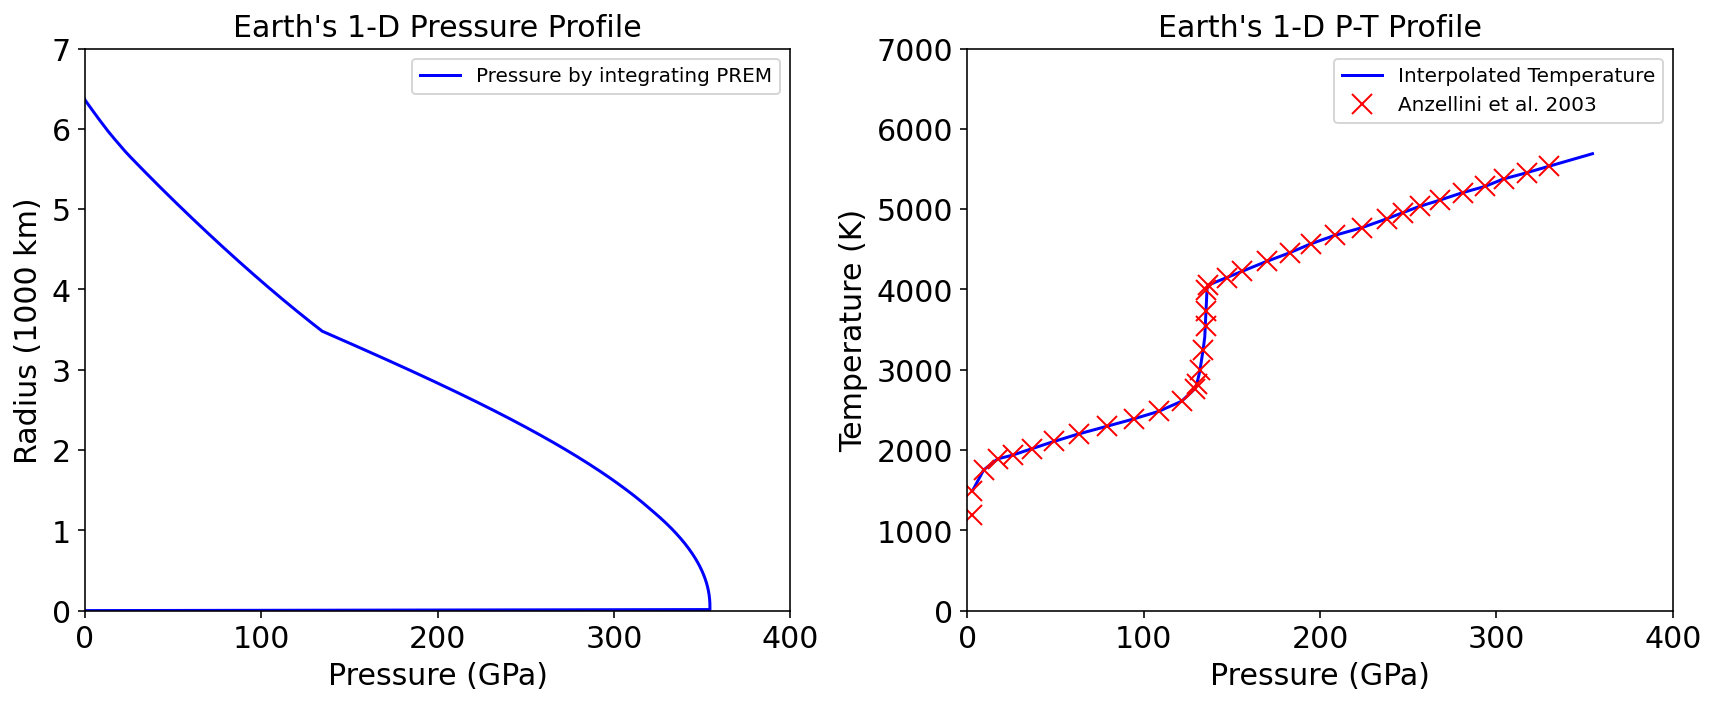

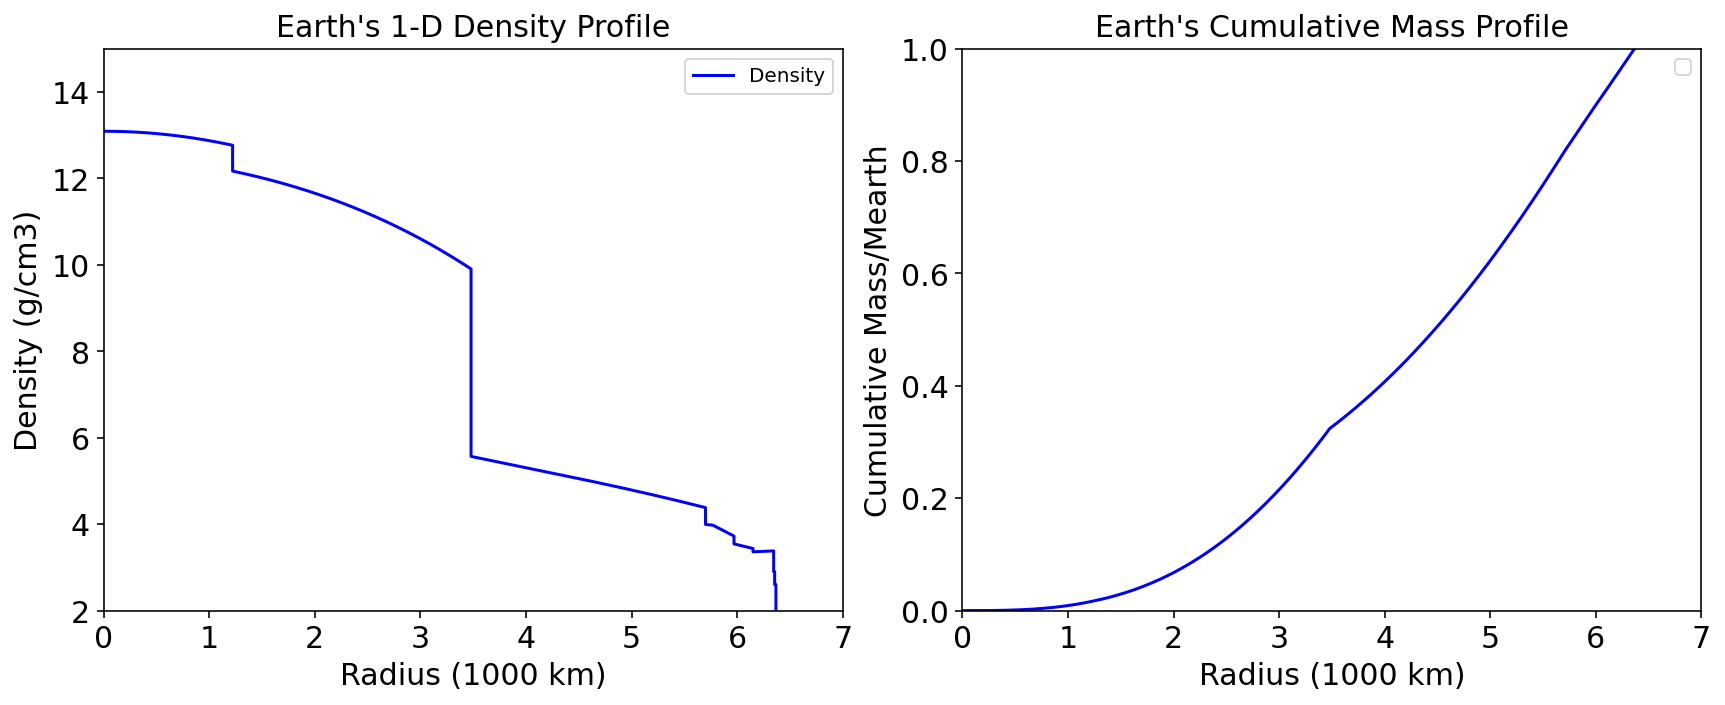

In [10]:
# make plots of pressure vs. temperature; pressure vs. radius

sfont=15 # I like to set the size of my fonts

# we just need 2 plots
fig, (ax0, ax1)= plt.subplots(ncols=2,figsize=(12,5))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.pressure,PREM.radius/1.E6,'-',color='blue',label='Pressure by integrating PREM')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,400.)
ax0.set_xlabel('Pressure (GPa)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Pressure Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pressure,PREM.temperature,'-',color='blue',label='Interpolated Temperature')
ax1.plot(Anzellini_pressure,Anzellini_temperature,'x',color='red',label='Anzellini et al. 2003',markersize=10)

ax1.set_ylim(0.,7000.)
ax1.set_xlim(0,400.)
ax1.set_xlabel('Pressure (GPa)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Earth\'s 1-D P-T Profile',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)


# we just need 2 plots
fig, (ax0, ax1)= plt.subplots(ncols=2,figsize=(12,5))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.radius/1.E6,PREM.density/1.E3,'-',color='blue',label='Density')
ax0.set_xlim(0.,7)
ax0.set_ylim(2,15.)
ax0.set_ylabel('Density (g/cm3)',size=sfont)
ax0.set_xlabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Density Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: cumulative mass vs. radius
ax1.plot(PREM.radius/1.E6,PREM_mass_enclosed/PREM_mass_enclosed[PREM.NR-1],'-',color='blue')

ax1.set_xlim(0.,7.)
ax1.set_ylim(0.,1.)
ax1.set_xlabel('Radius (1000 km)',size=sfont)
ax1.set_ylabel('Cumulative Mass/Mearth',size=sfont)
ax1.set_title('Earth\'s Cumulative Mass Profile',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
#plt.savefig('Earth-PT.pdf', format='pdf', dpi=300,transparent=True)


In [11]:
def CMB_rubie(mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    return np.power(mcore/(4/3*np.pi*rhocore),1/3)

def P_rubie(r,rCMB,rplanet,mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    b = np.power(mcore/(4/3*np.pi*rhocore),1/3)
    a = np.power((mmantle+4/3*rhomant*np.pi*b**3)/(4/3*np.pi*rhomant),1/3)
    #a = np.power(mplanet*M_earth/(4/3*np.pi*(1-(rhomant/7/(rhocore/3+rhomant/7))*(rhocore-rhomant))),1/3)
    #b = rplanet*R_earth*np.power(4/7*rhomant/(4/3*rhocore + 4/7*rhomant),1/3)
    #a = rplanet*R_earth
    #b = rCMB*R_earth
    if (r<=a and r>=b):
        return 4/3*np.pi*rhomant*G_mks*b**3*(rhocore-rhomant)*(1/r-1/a) + 2/3*np.pi*G_mks*rhomant**2*(a**2-r**2)
    if (r>0 and r<b):
        return 2/3*np.pi*G_mks*rhocore**2*(b**2-r**2) + 2/3*np.pi*G_mks*rhomant**2*(a**2-b**2) + 4/3*np.pi*rhomant*G_mks*b**3*(rhocore-rhomant)*(1/b-1/a)

def T_rubie(P):
    P=P/1.e9
    if P<24:
        return 1874 + 55.43*P - 1.74*P**2 + 0.0193*P**3
    if P>=24:
        return 1249 + 58.28*P - 0.395*P**2 + 0.0011*P**3

## Code for new planet generator

In [12]:
# calculate the structure for one planet
class isentrope_class:
    """Class to isentrope data extracted from EOS table."""  # this is a documentation string for this class
    def __init__(self,entropy=None): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.entropy = entropy
        self.ND = 0 # number of density points
        self.density     = []   
        self.pressure    = []
        self.temperature = []
        self.soundspeed  = []
        self.energy      = []
        # not going to use all the variables in the file
        self.units = '' # I like to keep a text note in a structure about the units

class planet_profile:
    def __init__(self,file=None):
        self.file=file
        self.M = 0.
        self.cf = 0.
        self.rarr = np.array([])
        self.density = np.array([])
        self.pressure = np.array([])
        self.temperature = np.array([])
        self.energy = np.array([])
        self.entropy = np.array([])
        self.mat = np.array([])
        self.mass = np.array([])
        self.units = 'cgs'
        self.iendcore=0
        if file is not None:
            self.load(file)
        
    def load(self,file='profile.txt'):
        self.rarr,self.density,self.temperature,self.pressure,self.energy,self.entropy,self.mass,self.mat=np.loadtxt(file,skiprows=1,unpack=True)
        self.M=self.mass[-1]
        self.file=file
        
    def convert_to_mks(self):
        if self.units!='mks':
            self.rarr = self.rarr * 1.e-2            #cm to m
            self.density = self.density * 1.e3       #g/cm^3 to kg/m^3
            self.pressure = self.pressure * 1.e-1    #dyne/cm^2 to Pa
            self.energy = self.energy * 1.e-4        #erg/g to J/kg
            self.entropy = self.entropy * 1.e-4      #erg/g/K to J/kg/K
            self.mass = self.mass * 1.e-3            #g to kg
            self.M = self.mass[-1]
            self.units = 'mks'
            
    def convert_to_cgs(self):
        if self.units!='cgs':
            self.rarr = self.rarr * 1.e2            #m to cm
            self.density = self.density * 1.e-3       #kg/m^3 to g/cm^3
            self.pressure = self.pressure * 1.e1    #Pa to dyne/cm^2
            self.energy = self.energy * 1.e4        #J/kg to erg/g
            self.entropy = self.entropy * 1.e4      #J/kg/K to erg/g/K
            self.mass = self.mass * 1.e3            #kg to g
            self.M = self.mass[-1]
            self.units = 'cgs'
            
    def write(self,file='profile.txt'):
        self.convert_to_cgs()
        with open(file,"w") as outfile: # open the file for writing
            outfile.write("#radius[cm] density[g/cm^3] temperature[K] pressure[dyne/cm^2] sp.energy[erg/g] sp.entropy[erg/g/K] menclosed[g] matID\n")
            for i in range(0,len(self.rarr)):
                outfile.write("{:.8e} {:.8e} {:.8e} {:.8e} {:.8e} {:.8e} {:.8e} {:g}\n".format(self.rarr[i],self.density[i],self.temperature[i],self.pressure[i],self.energy[i],self.entropy[i],self.mass[i],self.mat[i]))
        

In [13]:


# function to find potential temperature
# refP [Pa], refT [K], EOS
def potentialT(refP,refT,EOS):
    refP_T = np.zeros(EOS.NT)
    refP_S = np.zeros(EOS.NT)
    refP_rho = np.zeros(EOS.NT)
    id0 = np.arange(EOS.ND)
    for iit in range(0,EOS.NT):
        refP_T[iit] = EOS.T[iit]
        refP_S[iit] = np.interp(refP/1.E10,EOS.P[iit,id0],EOS.S[iit,id0])
        refP_rho[iit] = np.interp(refP/1.E10,EOS.P[iit,id0],EOS.rho[id0])
    Sval = np.interp(refT,refP_T,refP_S)*1e3 # kJ/kg/K
    return Sval

def make_1D_planet(mass=Mearth,corefraction=0.325,Pmin=1.e6,Score=1.81,Smantle=3.02,mtolerance=1e-3,layer1='iron',layer2='forsterite',mantlepotT=False,corepotT=False,plot=False,fixcoreT=False,verbose=False,swift=False,Score_accept=True):
    
    mcore = corefraction * mass
    mmantle = (1-corefraction) * mass

    mtotal = mcore + mmantle

    Pcenter = 0
    
    if layer1 == 'iron':
        ly1EOS = IronEOS
        swift_coreID = 401
    elif layer1 == 'alloy':
        ly1EOS = AlloyEOS
        swift_coreID = 402
    else:
        print('Unknown core EOS')
        return
    
    if layer2 == 'forsterite':
        ly2EOS = ForsteriteEOS
        swift_mantleID = 400
    elif layer2 == 'pyrolite':
        ly2EOS = PyroliteEOS
        swift_mantleID = 403
    else:
        print('Unknown mantle EOS')
        return
    
    Score_setting=None
    Smantle_setting=None
    Smantle_accept=True
    
    # Potential temperature takes priority
    if mantlepotT:
        Smantle = potentialT(Pmin,mantlepotT,ly2EOS)

    if corepotT:
        Score = 1.81
        Score_setting = 'temp'
        Score_accept = False
        
    # prevent circular logic
    if Score=='mantle' and Smantle=='hot':
        Score=='warm'
    
    if Smantle =='warm':
        Smantle=np.interp(Pmin/1.E10,ly2EOS.mc.Ps,ly2EOS.mc.Ss)*1.E3
    if Smantle == 'hot':
        Smantle = 3.02
        Smantle_setting='hot'
        Smantle_accept = False
    if Smantle == 'peridotite':
        Smantle = potentialT(peridotitesolidusdatarr.iloc[:,0].values[0],peridotitesolidusdatarr.iloc[:,1].values[0],ly2EOS)
        
    if Score == 'warm':
        Score = 1.81
        Score_setting = 'warm'
        Score_accept = False
    if Score == 'hot':
        Score = 2.0
        Score_setting = 'hot'
        Score_accept = False
    if Score == 'melt':
        Score = 1.8
        Score_setting = 'melt'
        Score_accept = False
    if Score == 'cold':
        Score = 1.8
        Score_setting = 'cold'
        Score_accept = False
    if Score == 'mantle':
        Score = 1.8
        Score_setting = 'mantle'
        Score_accept = False
    
    #if unrecognized string setting, set to warm
    if type(Smantle)==str:
        print('Warning: unrecognized mantle setting string, defaulting to warm')
        Smantle=np.interp(Pmin/1.E10,ly2EOS.mc.Ps,ly2EOS.mc.Ss)*1.E3
    if type(Score)==str:
        print('Warning: unrecognized core setting string, defaulting to warm')
        Score = 1.81
        Score_setting = 'warm'
        Score_accept = False

    # interp function for peridotite solidus pressure-temperature
    # GPa, K
    pdt_solidus = interpolate.interp1d(peridotitesolidusdatarr.iloc[:,0].values,peridotitesolidusdatarr.iloc[:,1].values)
    
    Tcmb_accept = False
    while not Tcmb_accept:
        # first extract the isentropes for the planet from the EOS tables
        mantle = isentrope_class(entropy=Smantle)

        # loop across all densities and extract the values for the requested isentrope
        for i in range(0,ly2EOS.ND):
            ind = np.where((ly2EOS.S[:,i] > 0))[0]
            interpfunction = interpolate.interp1d(ly2EOS.S[ind,i],ly2EOS.P[ind,i]) # MJ/K/kg, GPa
            mantle.pressure = np.append(mantle.pressure,interpfunction(Smantle/1.E3)) # GPa
            interpfunction = interpolate.interp1d(ly2EOS.S[ind,i],ly2EOS.T[ind]) # MJ/K/kg, GPa
            mantle.temperature = np.append(mantle.temperature,interpfunction(Smantle/1.E3)) # GPa
            interpfunction = interpolate.interp1d(ly2EOS.S[ind,i],ly2EOS.U[ind,i]) # MJ/kg/K, MJ/kg
            mantle.energy = np.append(mantle.energy,interpfunction(Smantle/1.E3)) # MJ/kg
        mantle.density = ly2EOS.rho # g/cm3
        
        core = isentrope_class(entropy=Score)

        # loop across all densities and extract the values for the requested isentrope
        for i in range(0,ly1EOS.ND):
            ind = np.where((ly1EOS.S[:,i] > 0))[0]
            interpfunction = interpolate.interp1d(ly1EOS.S[ind,i],ly1EOS.P[ind,i]) # MJ/K/kg, GPa
            core.pressure = np.append(core.pressure,interpfunction(Score/1.E3)) # GPa
            interpfunction = interpolate.interp1d(ly1EOS.S[ind,i],ly1EOS.T[ind]) # MJ/K/kg, K
            core.temperature = np.append(core.temperature,interpfunction(Score/1.E3)) # K
            interpfunction = interpolate.interp1d(ly1EOS.S[ind,i],ly1EOS.U[ind,i]) # MJ/K/kg, MJ/kg
            core.energy = np.append(core.energy,interpfunction(Score/1.E3)) # MJ/kg
        core.density = ly1EOS.rho # g/cm3


        if plot:
            fig = plt.figure(figsize=(7,5))
            plt.plot(PREM.pressure,PREM.temperature,'-.',color='xkcd:deep blue',label='PREM profile')
            plt.plot(mantle.pressure,mantle.temperature,'-',color='xkcd:purple',label='mantle isentrope',markersize=10)
            plt.plot(core.pressure,core.temperature,'-',color='xkcd:tangerine',label='core isentrope',markersize=10)

            plt.plot(ly2EOS.mc.Pl,ly2EOS.mc.T,'-',color='black',label='forsterite MC',markersize=10)
            plt.plot(ly1EOS.mc.Pl,ly1EOS.mc.T,'--',color='black',label='iron MC',markersize=10)

            plt.ylim(0.,max(PREM.temperature))
            plt.xlim(0,max(PREM.pressure))
            plt.xlabel('Pressure (GPa)')
            plt.ylabel('Temperature (K)')
            plt.legend()
            plt.show()

        # this part was all trial-and-error to make the iterative process work 'nicely'
        factors = np.array([0.0008,0.0014,0.002,0.05,0.08,0.16,0.3,0.5,0.8,0.8])
        densities  = np.array([7.1,7.15,7.2,7.25,7.5,8.5,11.,13.,16.,20.])
        masses = np.array([0.00001,0.00002,0.0002,0.002,0.01,0.02,0.5,1.0,2.0,5.])

        changefac = np.interp(mtotal/Mearth,masses,factors)
        rhocenter = np.interp(mtotal/Mearth,masses,densities)

        if verbose:
            print('m:',mtotal/Mearth,'fac:',changefac,' rho:',rhocenter )

        r_est = (mtotal/(4./3.*np.pi*rhocenter/2.))**(1./3.)
        dR = np.floor(r_est/1e5)*1e5 / 3000
        if dR < 0.025e5:
            dR = 0.025e5

        #dM = menclosed/msteps
        menclosed = 0.
        marr = np.zeros(1)
        rhoi = Pi = 0.

        rhoi = rhocenter

        #if rhocenter:
        #if Pcenter:
        #    Pi = Pcenter
        darr = np.full(1,rhoi)
        parr = np.full(1,Pi)

        itercount = 0
        maxiter = 20000
        maxiterm = 4000

        if mtolerance < 5e-4:
            changefac *= 0.2
            maxiterm *= 3
            dR *= 0.3
        elif mtolerance < 1e-3:
            changefac *= 0.4
            maxiterm *= 1.2
            dR *= 0.8

        if verbose:
            print('dR: ',dR/1e5, 'km')

        while np.abs(mtotal-menclosed)/mtotal > mtolerance and itercount < maxiter:
            # USE MKS FOR THIS INTEGRAL
            if (itercount%100 == 0 and verbose) or (itercount%10000 == 0 and itercount!=0):
                print(parr[0],darr[0],menclosed/mtotal)
            rarr = np.zeros(1)
            ii=1
            ri = rarr[0]

            darr = np.full(1,rhoi) # Pa
            parr = np.full(1,np.interp(rhoi,core.density,core.pressure)*1.E10) # 
            #if rhocenter:
            #else:
            #    parr = np.full(1,Pi) # Pa
            #    darr = np.full(1,np.interp(Pi/1.E10,core.pressure,core.density)*1.E3) # kg/m3

            tarr = np.full(1,np.interp(rhoi,core.density,core.temperature)) # K
            uarr = np.full(1,np.interp(rhoi,core.density,core.energy)) # MJ/kg
            #tarr = np.full(1,np.interp(parr[0]/1.E10,core.pressure,core.temperature)) # K
            menclosed = 0
            marr = np.zeros(1)

            ri = rarr[0]
            ii=1

            coreiter=0

            while menclosed < mcore and parr[ii-1] > Pmin and coreiter < maxiterm:
                ri +=dR # m
                rarr = np.append(rarr,ri)
                mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # g
                if ii == 1:
                    dp = G*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
                else:
                    dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
                parr = np.append(parr, parr[ii-1]-dp) # 
                di = np.interp(parr[ii]/1.E10,core.pressure,core.density) # g/cm3
                darr = np.append(darr,di) # g/cm3
                ti = np.interp(parr[ii]/1.E10,core.pressure,core.temperature) # K
                tarr = np.append(tarr,ti) # K
                ui = np.interp(darr[ii],core.density,core.energy) # MJ/kg
                uarr = np.append(uarr,ui) # MJ/kg
                menclosed = menclosed + mlayer # kg
                marr = np.append(marr,menclosed)
                #print(np.mod(ii,10))
                #print(ii,mlayer,menclosed/Mearth,di,ri,dp,parr[ii]/1.E10)
                ii += 1
                coreiter += 1
            iendcore=ii-1

            dmantle = np.interp(parr[ii-1]/1.E10,mantle.pressure,mantle.density) # g/m3

            mantleiter = 0

            while parr[ii-1] > Pmin and mantleiter< maxiterm:
                ri += dR # m
                rarr = np.append(rarr,ri)
                mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # kg
                #mlayer = 4.*np.pi*ri*ri*dR*darr[ii-1] # kg
                if ii == iendcore+1:
                    if menclosed > 0:
                        dp = G*menclosed*dmantle*dR/rarr[ii]/rarr[ii] # Pa
                        #dp = G*menclosed*dmantle*dR/ri/ri # Pa
                    else:
                        dp = G*dmantle*dR/ri/ri # Pa
                else:
                    dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
                    #dp = G*menclosed*darr[ii-1]*dR/ri/ri # Pa
                #parr = np.append(parr, parr[ii-1]-dp) # Pa
                if (parr[ii-1]-dp) < Pmin:
                    print('surface pressure too low, P: ',parr[ii-1]-dp)
                    print('dR: ',dR)
                    ri -= dR
                    dp = parr[ii-1]-Pmin
                    dRR = (G*menclosed*darr[ii-1]/dp-2*ri-np.sqrt((G*menclosed*darr[ii-1]/dp-2*ri)**2-4*ri**2))/2
                    ri += dRR
                    print('dRR: ',dRR,'(adjusted)')
                    print('current surface pressure: ',parr[ii-1]-dp,' Pmin: ',Pmin)
                    rarr[ii]=ri
                    mlayer = 4.*np.pi*ri*ri*dR*darr[ii-1] # kg    
                #rarr = np.append(rarr,ri)
                parr = np.append(parr, parr[ii-1]-dp) # Pa
                di = np.interp(parr[ii-1]/1.E10,mantle.pressure,mantle.density) # g/cm3
                darr = np.append(darr,di) # g/cm3
                ti = np.interp(parr[ii-1]/1.E10,mantle.pressure,mantle.temperature) # K
                tarr = np.append(tarr,ti) # kg/m3
                ui = np.interp(darr[ii],mantle.density,mantle.energy) # MJ/kg
                uarr = np.append(uarr,ui) # MJ/kg
                #print(parr[ii])
                ii=ii+1
                mantleiter += 1
                menclosed = menclosed + mlayer # kg
                marr = np.append(marr,menclosed)

            if menclosed < mtotal:
                #rhoi *= 1.0+2*mtolerance*changefac
                #Pi *= 1.0+2*mtolerance*changefac
                rhoi *= 1.0 + (0.04*(mtotal-menclosed)/mtotal + 1.8*mtolerance)*changefac
                #Pi *= 1.0+2*mtolerance*changefac
            elif menclosed > mtotal:
                #rhoi *= 1.0-1*mtolerance*changefac
                #Pi *= 1.0-1*mtolerance*changefac
                rhoi *= 1.0 - (0.02*(menclosed-mtotal)/mtotal + 0.5*mtolerance)*changefac
                #Pi *= 1.0-1*mtolerance*changefac

            itercount += 1
            
        if not fixcoreT:
            Tcmb_accept = True
    
        if (Score_accept==False):
            if Score_setting=='warm' and (np.abs(pdt_solidus(parr[iendcore]/1.E10)-tarr[iendcore])/tarr[iendcore])>=0.1*mtolerance:
                Score = potentialT(parr[iendcore],pdt_solidus(parr[iendcore]/1.E10),ly1EOS)
                print('Adjusting Score, new Score=',Score)
                print('CMB peridotite solidus T: ',pdt_solidus(parr[iendcore]/1.E10))
                print('Current CMB T:',tarr[iendcore])
                print('Current CMB P:',parr[iendcore])
            elif Score_setting=='warm' and (np.abs(pdt_solidus(parr[iendcore]/1.E10)-tarr[iendcore])/tarr[iendcore])<0.1*mtolerance:
                Score_accept=True
                
            
            if Score_setting=='temp' and np.abs(tarr[iendcore]-corepotT)>=0.1:
                Score = potentialT(parr[iendcore],corepotT,ly1EOS)
            elif Score_setting=='temp' and np.abs(tarr[iendcore]-corepotT)<0.1:
                Score_accept=True
                
            if Score_setting=='hot' and np.abs(tarr[iendcore]-np.interp(parr[iendcore]/1.E10,ly2EOS.mc.Pl,ly2EOS.mc.T))>=0.1:
                Score = potentialT(parr[iendcore],np.interp(parr[iendcore]/1.E10,ly2EOS.mc.Pl,ly2EOS.mc.T),ly1EOS)
            elif Score_setting=='hot' and np.abs(tarr[iendcore]-np.interp(parr[iendcore]/1.E10,ly2EOS.mc.Pl,ly2EOS.mc.T))<0.1:
                Score_accept=True
                
            if Score_setting=='melt' and np.abs(Score-np.interp(parr[0]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)/(np.interp(parr[0]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)>=mtolerance:
                Score = np.interp(parr[0]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3
                print('Adjusting Score, new Score=',Score)
                print('Current core T: ',np.interp(parr[0]/1.E10,core.pressure,core.temperature),'[',np.interp(parr[0]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.T),']')
            elif Score_setting=='melt' and np.abs(Score-np.interp(parr[0]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)/(np.interp(parr[0]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)<mtolerance:
                Score_accept=True
                
            if Score_setting =='cold' and np.abs(Score-np.interp(parr[iendcore]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)/(np.interp(parr[iendcore]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)>=mtolerance:
                Score = np.interp(parr[iendcore]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3
                print('Adjusting Score, new Score=',Score)
                print('Current CMB T: ',tarr[iendcore],'[',np.interp(parr[iendcore]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.T),']')
            elif Score_setting =='cold' and np.abs(Score-np.interp(parr[iendcore]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)/(np.interp(parr[iendcore]/1.E10,ly1EOS.mc.Ps,ly1EOS.mc.Ss)*1.E3)<mtolerance:
                Score_accept=True
                
        if Score_setting=='mantle' and np.abs(tarr[iendcore]-np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature))>=0.1:
            Score = potentialT(parr[iendcore],np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature),ly1EOS)
            print('Adjusting Score, new Score=',Smantle)
            print('Current CMB Temps:',tarr[iendcore],np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature))
        elif Score_setting=='mantle' and np.abs(tarr[iendcore]-np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature))<0.1:
            Score_accept=True
        
        if Smantle_setting=='hot' and np.abs(tarr[iendcore]-np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature))>=0.1:
            Smantle = potentialT(parr[iendcore],tarr[iendcore],ly2EOS)
            print('Adjusting Smantle, new Smantle=',Smantle)
            print('Current CMB Temps:',tarr[iendcore],np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature))
            Smantle_accept=False
        elif Smantle_setting=='hot' and np.abs(tarr[iendcore]-np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature))<0.1:
            Smantle_accept=True
            
        if ((tarr[iendcore]+0.05) < np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature)): #and Score_accept
            print('WARNING! Core colder than mantle!   {:10.3f}  {:10.3f}  | S: {:.3f}'.format(tarr[iendcore],np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature),Score))
                                
            if fixcoreT and (Score_setting==None or Score_setting=='mantle'):
                Score_setting = 'mantle'
                Score = potentialT(parr[iendcore],np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature),ly1EOS)
                print('Adjusting Score, new Score=',Score)
            elif fixcoreT:
                Smantle_setting='hot'
                Smantle = potentialT(parr[iendcore],tarr[iendcore],ly2EOS)
                print('Adjusting Smantle, new Smantle=',Smantle)
        else:
            if Score_accept and Smantle_accept: Tcmb_accept = True
            
    
    print('Iterations:    ',itercount,'\n')        

    planet = planet_profile()
    planet.M = menclosed
    planet.cf = mcore/menclosed
    planet.rarr = rarr
    planet.density = darr
    planet.pressure = parr
    planet.temperature = tarr
    if swift:
        planet.mat = np.where(np.arange(len(rarr))<=iendcore,swift_coreID,swift_mantleID)
    else:
        planet.mat = np.where(np.arange(len(rarr))<=iendcore,0,1)
    planet.entropy = np.where(np.arange(len(rarr))<=iendcore,Score,Smantle)*1e7
    planet.energy = uarr*1e10
    planet.mass = marr
    planet.iendcore=iendcore
    
    print('MODEL PLANET:')
    print('Score (kJ/K/kg)         = {:10.3f}'.format(Score))
    print('Smantle (kJ/K/kg)       = {:10.3f}'.format(Smantle))
    print('Tcmb (K)                = {:10.3f}  [{:10.3f}]'.format(tarr[iendcore],np.interp(parr[iendcore]/1.E10,mantle.pressure,mantle.temperature)))
    print('Mantle Tp (K)           = {:10.3f}'.format(tarr[-1])) #min(tarr)
    print('Pcenter (GPa)           = {:10.3f}'.format(parr[0]/1.E10))
    print('Tcenter (K)             = {:10.3f}'.format(tarr[0]))
    print('rho center (g/cm3)      = {:10.3f}'.format(darr[0]))
    print('Core radius (km, Rcmb)  = {:10.3f}{:10.3f}'.format(rarr[iendcore]/1.e5,rarr[iendcore]/Rcmb))
    print('CMB pressure (GPa)      = {:10.3f}'.format(parr[iendcore]/1.E10))
    print('Radius (km, Rearth)     = {:10.3f}{:10.3f}'.format(rarr[-1]/1.e5,rarr[-1]/Rearth))
    print('Surface pressure (GPa)  = {:10.3f}'.format(parr[-1]/1.E10))
    print('Surface pressure (Pa)   = {:10.3f}'.format(parr[-1]))
    print('Surface gravity (m/s2)  = {:10.3f}'.format(G*menclosed/rarr[-1]/rarr[-1]/100.))
    print('Vesc (km/s)             = {:10.3f}'.format(np.sqrt(2*G*menclosed/rarr[-1])/1.E5))
    print('Mass/Mearth, Mcore/Mass = {:10.5f}{:10.4f}'.format(menclosed/Mearth, mcore/menclosed))
    
    return planet,core,mantle


#### Test cell containing sample profiles

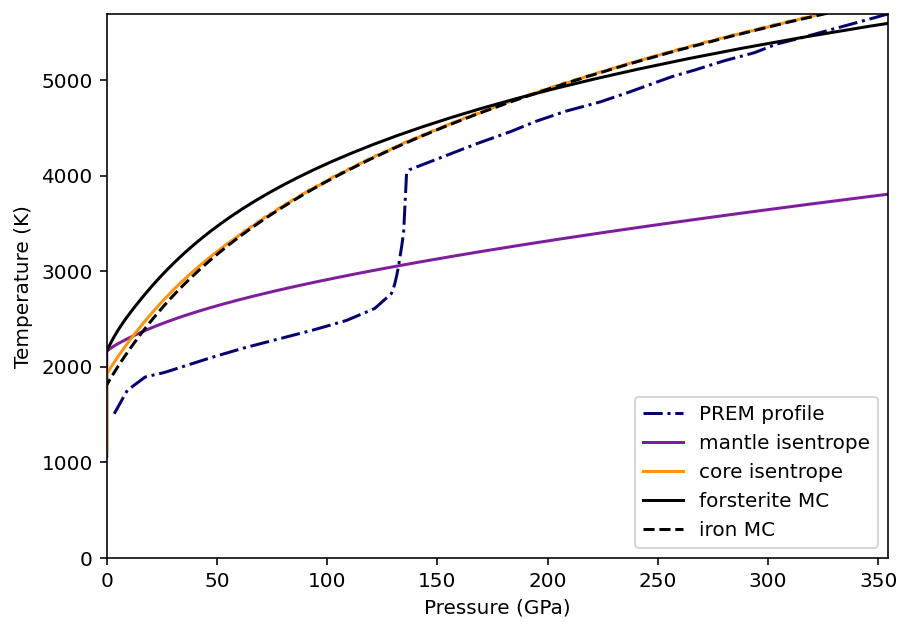

surface pressure too low, P:  -54179337.03036779
dR:  201000.0
dRR:  179924.19287109375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -271871701.2292648
dR:  201000.0
dRR:  97760.87158203125 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -107553458.14605373
dR:  201000.0
dRR:  160286.49487304688 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -273080454.7907678
dR:  201000.0
dRR:  99003.05615234375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -38191173.35427678
dR:  201000.0
dRR:  186517.04052734375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -98983727.06639421
dR:  201000.0
dRR:  164276.28515625 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -298848889.5791081
dR:  201000.0
dRR:  91450.16796

In [14]:
mass = 1 * Mearth
corefraction = 0.30
Score   = 1.85 # kJ/K/kg #1.80
Smantle = 3.027 # kJ/K/kg #3.027
mantlepotT = False #2162
coremat = 'iron'

Pmin = 1.E6  # 0.1 Pa [barye] (1e6 = 1 bar)
mtolerance = 1e-3


Rmars=3390.E5 # cm
Rmarscore = 1797.E5 # cm Heffrich 2017
Mmars=6.39E26 # g


exampleplanet = 0

if exampleplanet == 1: # COLD MARS
    mass = 1. * Mmars
    corefraction = 0.25
    mantlepotT = False #2162
    Score = 1.8 # MJ/K/kg
    Smantle = 2.8 # MJ/K/kg See Fei & Berka Science 2005
    Pmin = 1.E4  # Pa (1 bar)

if exampleplanet == 2: # WARM MARS
    mass = 1. * Mmars
    corefraction = 0.25
    mantlepotT = False #2162
    Score = 1.8 # MJ/K/kg
    Smantle = 3.1 # MJ/K/kg -- Makes mantle temperature continuous with core
    Pmin = 1.E4  # Pa (1 bar)

if exampleplanet == 3: # WARM HALF-EARTH
    mass = 0.5 * Mearth
    corefraction = 0.3
    Score   = 1.75 # MJ/K/kg
    Smantle = 3.1 # MJ/K/kg
    Pmin = 1.E6  # Pa (1 bar)

if exampleplanet == 4: # WARM 0.9Mearth PLANET
    mass = 0.9 * Mearth
    corefraction = 0.3
    Score   = 1.81 # MJ/K/kg
    Smantle = 3.0277 # MJ/K/kg
    Pmin = 1.E6  # Pa (1 bar)

if exampleplanet == 5: # WARM 0.13Mearth PLANET
    mass = 0.13 * Mearth
    corefraction = 0.3
    Score   = 1.8 # MJ/K/kg
    Smantle = 3.0277 # MJ/K/kg
    Pmin = 1.E6  # Pa (1 bar)

if exampleplanet == 6: # WARM 0.57Mearth PLANET
    mass = 0.57 * Mearth
    corefraction = 0.3
    Score   = 1.8 # MJ/K/kg
    Smantle = 3.0277 # MJ/K/kg
    Pmin = 1.E6  # Pa (1 bar)


planet,core,mantle = make_1D_planet(plot=True,mantlepotT=mantlepotT,layer1=coremat,mass=mass,corefraction=corefraction,Pmin=Pmin,Score=Score,Smantle=Smantle,mtolerance=mtolerance)

In [15]:
SHOWSWIFTDATA=1
if SHOWSWIFTDATA:
    import woma
    import h5py
    import swiftsimio as sw
    from swiftsimio.objects import cosmo_array
    from woma.misc import glob_vars as gv
    from woma.eos import sesame
    from woma.eos.T_rho import T_rho
    from woma.misc import utils, io
    R_earth = gv.R_earth#6.371e6   # m
    M_earth = gv.M_earth#5.9724e24  # kg
    Gmks = gv.G #6.67408e-11  # m^3 kg^-1 s^-2
    G = Gmks*1.e3 #CGS
    woma.load_eos_tables()
    swift_datadir="C:/Users/gerri/swift-tutorial/survey data/mass1to2/halfearth/halfearth0.5x0.25th30/" #add specific simulation run here
    basename = swift_datadir+'halfearth0.5x0.25v1.15th30' #add basename here
    snapshot_no = 288
    mant_mat_id = 403 #USER INPUT
    core_mat_id = 402 #USER INPUT
    snapshot = basename+'_%04d.hdf5' % snapshot_no
    data = sw.load(snapshot)
    data.gas.pressures.convert_to_mks()
    data.gas.internal_energies.convert_to_mks()
    data.gas.masses.convert_to_mks()
    data.gas.densities.convert_to_mks()
    data.gas.coordinates.convert_to_mks()
    
    mat_id = data.gas.material_ids.value
    pres = data.gas.pressures.value
    u = data.gas.internal_energies.value
    rho = data.gas.densities.value
    tmp_s = np.zeros(np.size(pres))
    tmp_T = np.zeros(np.size(pres))
    for i in range(np.size(pres)):
        tmp_s[i] = sesame.s_u_rho(u[i],rho[i],mat_id[i])
        tmp_T[i] = sesame.T_rho_s(rho[i],tmp_s[i],mat_id[i]) #NOTE: this values will use the woma EOS table
    
    Ncenter = 200
    #this function finds the center of mass of the mantle particles with lowest PE
    #returns all of the data, with coordinate positions and velocities shifted
    part_id = data.gas.particle_ids.value
    pos = data.gas.coordinates
    boxsize = data.metadata.boxsize.value
    print(pos)
    pos_x = pos.value[:,0]-boxsize[0]/2*R_earth 
    pos_y = pos.value[:,1]-boxsize[1]/2*R_earth 
    pos_z = pos.value[:,2]-boxsize[2]/2*R_earth 
    vel = data.gas.velocities
    vel_x = vel.value[:,0] 
    vel_y = vel.value[:,1] 
    vel_z = vel.value[:,2] 
    m = data.gas.masses.value
    pot = data.gas.potentials.value
    
    indmantle = np.where(mat_id == mant_mat_id)
    indcore = np.where(mat_id == core_mat_id)
    
    coreSort = np.argsort(pot[indcore])
    xcm = np.mean(pos_x[indcore][coreSort[0:Ncenter]])
    ycm = np.mean(pos_y[indcore][coreSort[0:Ncenter]])
    zcm = np.mean(pos_z[indcore][coreSort[0:Ncenter]])
    vxcm = np.mean(vel_x[indcore][coreSort[0:Ncenter]])
    vycm = np.mean(vel_y[indcore][coreSort[0:Ncenter]])
    vzcm = np.mean(vel_z[indcore][coreSort[0:Ncenter]])
    bndm = np.sum(m[indcore][coreSort])
    oldBoundPot = np.mean(pot[indcore][coreSort[0:Ncenter]])
    print('center: ', xcm/R_earth, ycm/R_earth, zcm/R_earth)
    
    #iterating - still not entirely confident about what's going on here - update: maybe more confident
    #testing this with just bound core mass at the moment? might see how things differ
    bndflag=np.zeros(np.shape(m)[0])
    newm = bndm/10.0
    tolerance = 1.E-3 #or just choose another value idk
    nn=0
    while(np.absolute((newm-bndm)/newm)>tolerance and nn<50):
        print(nn)
        nn=nn+1
        bndm = newm
        #finding KE and PE of all particles
        v2 = np.power(vel_x-vxcm,2.0) + np.power(vel_y-vycm,2.0) + np.power(vel_z-vzcm,2.0)
        r = np.sqrt(np.power(pos_x-xcm,2.0) + np.power(pos_y-ycm,2.0) + np.power(pos_z-zcm,2.0))
        KE = 0.5 * m * v2
        PE = -1*G * bndm * np.divide(m,r)
        
        indbnd = np.where(KE+PE < 0.0)
        bndflag[indbnd]=1
        indesc = np.where(KE+PE >= 0.0)
        bndflag[indesc]=0

        print('Nbound: ',np.shape(indbnd)[1])
        
        #recalculate bound and escaping mass
        newm = np.sum(m[indbnd])
        escm = np.sum(m[indesc])

        indbndCore = np.where((mat_id == core_mat_id) & (KE+PE < 0.0))
        boundSort = np.argsort(pot[indbndCore])
        #newBoundPot = np.mean(PE[boundSort[0:Ncenter]])
        newBoundPot = np.mean(pot[indbndCore][boundSort[0:Ncenter]])
        print(oldBoundPot)
        #reset center to lowest Ncenter potentials of bound core mass
        if (np.shape(indbndCore)[1] > Ncenter and newBoundPot<oldBoundPot):
            oldBoundPot = newBoundPot
            xcm = np.mean(pos_x[indbndCore][boundSort[0:Ncenter]])
            ycm = np.mean(pos_y[indbndCore][boundSort[0:Ncenter]])
            zcm = np.mean(pos_z[indbndCore][boundSort[0:Ncenter]])
            vxcm = np.mean(vel_x[indbndCore][boundSort[0:Ncenter]])
            vycm = np.mean(vel_y[indbndCore][boundSort[0:Ncenter]])
            vzcm = np.mean(vel_z[indbndCore][boundSort[0:Ncenter]])
        
        print('bound mass: ',bndm/M_earth,' | new mass: ',newm/M_earth,' | diff: ',np.absolute(newm-bndm)/M_earth)
        print('center: ', xcm/R_earth, ycm/R_earth, zcm/R_earth)
        
    #moving planet back into central frame
    for i in range(len(m)):
        pos[i,0] = pos_x[i] - xcm #+ boxsize[0]/2*R_earth
        pos[i,1] = pos_y[i] - ycm #+ boxsize[1]/2*R_earth
        pos[i,2] = pos_z[i] - zcm #+ boxsize[2]/2*R_earth
        vel[i,0] = vel_x[i] - vxcm
        vel[i,1] = vel_y[i] - vycm
        vel[i,2] = vel_z[i] - vzcm
    
    rrr = np.sqrt((pos[:,0])**2 + (pos[:,1])**2 + (pos[:,2])**2)
    vvv = np.sqrt((vel[:,0])**2 + (vel[:,1])**2 + (vel[:,2])**2)
    planetind=np.where(pres[indbnd]>1.e8)
    argplanetv=np.argmax(vvv[indbnd][planetind])
    planetR=rrr[indbnd][planetind][argplanetv]
    print('Planet radius: ',planetR/R_earth)
    indplanet=np.where(rrr<planetR)
    indeq=np.where((rrr<planetR)&(np.abs(pos[:,2])<planetR/10))
    mplanet=np.sum(m[indplanet])
    print(mplanet/M_earth)
    indcore=np.where(mat_id[indeq]==core_mat_id)
    indmant=np.where(mat_id[indeq]==mant_mat_id)

Could not find gas gamma, assuming 5./3.
[[1.48917781e+10 1.57649501e+10 1.58144521e+10]
 [1.53481152e+10 1.59146952e+10 1.48351871e+10]
 [1.53666496e+10 1.56306913e+10 1.44043492e+10]
 ...
 [1.60358966e+10 1.60082778e+10 1.69760671e+10]
 [1.61358878e+10 1.60580610e+10 1.71028467e+10]
 [1.60903004e+10 1.60463240e+10 1.75969716e+10]] m (Comoving)
center:  -0.010916774329907142 0.0004263645032248903 0.08798349952969742
0
Nbound:  208120
-1.942724e-06
bound mass:  0.022508686293861643  | new mass:  0.7494682799200003  | diff:  0.7269595936261387
center:  -0.010916774329907142 0.0004263645032248903 0.08798349952969742
1
Nbound:  208120
-1.942724e-06
bound mass:  0.7494682799200003  | new mass:  0.7494682799200003  | diff:  0.0
center:  -0.010916774329907142 0.0004263645032248903 0.08798349952969742
Planet radius:  1.3836162818818085 m
0.7057297402044045


In [16]:
def make_SPH_planet_SWIFT(mass=Mearth,corefraction=0.3,Pmin=1.e6,Score=1.81,Smantle=3.03,mtolerance=1e-3,layer1='alloy',layer2='forsterite',mantlepotT=False,corepotT=False,plot=False,resolution=5e5,fixcoreT=False,verbose=False,outname=None,box_size=80*Rearth):
    
    planet,core,mantle = make_1D_planet(plot=plot,mantlepotT=mantlepotT,corepotT=corepotT,layer1=layer1,layer2=layer2,mass=mass,corefraction=corefraction,Pmin=Pmin,Score=Score,Smantle=Smantle,mtolerance=mtolerance,fixcoreT=fixcoreT,verbose=verbose,swift=True)
    
    if layer1=='alloy': coreID=402
    elif layer1=='iron': coreID=401
    if layer2=='forsterite': mantleID=400
    elif layer2=='pyrolite': mantleID=403
    
    partmass = Mearth / resolution

    Np = int(planet.M / partmass)
    
    if verbose:
        print(partmass,Np)
        print(planet.rarr)
    
    #planet.rarr[0]=1e-10
    particleplanet=seagen.GenSphere(Np,planet.rarr[1:],planet.density[1:],A1_T_prof=planet.temperature[1:],A1_P_prof=planet.pressure[1:],A1_u_prof=planet.energy[1:],A1_mat_prof=planet.mat[1:],verbosity=0, A1_m_rel_prof=1.0*np.ones(len(planet.mat[1:])))#, A1_force_more_shells=[False,True])
    setattr(particleplanet,"A1_s",np.where(particleplanet.mat==coreID,core.entropy*1e7,mantle.entropy*1e7))
    
    indcore = np.where(particleplanet.mat==coreID)
    indmantle = np.where(particleplanet.mat==mantleID)
    corefracSPH=np.sum(particleplanet.A1_m[indcore])/np.sum(particleplanet.A1_m)
    
    A1_vx = np.zeros_like(particleplanet.A1_x)
    A1_vy = np.zeros_like(particleplanet.A1_y)
    A1_vz = np.zeros_like(particleplanet.A1_z)
    
    # 2D position and velocity arrays
    A2_pos = np.transpose([particleplanet.A1_x, particleplanet.A1_y, particleplanet.A1_z])
    setattr(particleplanet,"A2_pos",A2_pos)
    A2_vel = np.transpose([A1_vx, A1_vy, A1_vz])
    setattr(particleplanet,"A2_vel",A2_vel)
    
    # Smoothing lengths, crudely estimated from the densities
    w_edge = 2  # r/h at which the kernel goes to zero
    A1_h = np.cbrt(48 * particleplanet.A1_m / (4 / 3 * np.pi * particleplanet.A1_rho)) / w_edge
    setattr(particleplanet,'A1_h',A1_h)

    if verbose:
        print(np.unique(particleplanet.A1_m))
        print( (particleplanet.A1_m.max()-np.mean(particleplanet.A1_m))/np.mean(particleplanet.A1_m), (particleplanet.A1_m.min()-np.mean(particleplanet.A1_m))/np.mean(particleplanet.A1_m) )

    if plot:
        zcut=50e5
        plt.scatter(particleplanet.A1_x[np.abs(particleplanet.z)<zcut]/1e5,particleplanet.A1_y[np.abs(particleplanet.z)<zcut]/1e5,c=particleplanet.rho[np.abs(particleplanet.z)<zcut])
        plt.axis('equal')
        plt.colorbar()
        plt.show()

    print('N:',particleplanet.N_picle)
    massresid = partmass-np.unique(particleplanet.A1_m)
    if verbose:
        print('pm:',massresid.min()/partmass,massresid.max()/partmass)

   # write the isolated planet file 

   # first check if file exists; if so, ask to delete it
    if outname==None:
        outname = input("Please specify an output filename: ")
    if (os.path.isfile(outname)):
        input("Output file name exists already; press enter to delete it and write new file: "+outname)
        !del -f $outname
    with h5py.File(outname, "w") as f:
        woma.save_particle_data( # when no particle ID number is passed in, will generate integers in order of particles
            f,
            particleplanet.A2_pos/100.,
            particleplanet.A2_vel/100., 
            particleplanet.A1_m/1000.,
            particleplanet.A1_h/100.,
            particleplanet.A1_rho/1.E-3,
            particleplanet.A1_P*1.E-1,
            particleplanet.A1_u/1.E4,
            particleplanet.A1_mat,
            A1_s=particleplanet.A1_s/1.E4,
            boxsize=box_size/100,
            file_to_SI=woma.Conversions(gv.M_earth, gv.R_earth, 1), # mass, length, time  # calculation is done in scaled internal units
        )
    # write planet profiles to text file
    # assuming a filename ending with .hdf5
    outtxtname=''.join(np.char.add(outname.split('.')[:-1],'.'))+'txt'
    planet.write(outtxtname)
    print('Saved ',outtxtname)
    
    inname_out = ''.join(np.char.add(outname.split('.')[:-1],'.'))+'used_params.txt'
    with open(inname_out,"w") as outfile:
        outfile.write('#filename coremat mantlemat NSPH inputMass[M_earth] mass[M_earth] SPHmass[M_earth] corefrac SPHcorefrac radius[R_earth] Rcore[R_earth] Score[kJ/kg/K] Smantle[kJ/kg/K] Pcenter[GPa] PCMB[GPa] Pmin[Gpa] TCMB[K] Tsurf[K] mtolerance resolution \n')
        outfile.write('{:s} {:s} {:s} {:g} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8e}'.format(outname,layer1,layer2,particleplanet.N_picle,mass/Mearth,planet.mass[-1]/Mearth,np.sum(particleplanet.A1_m)/Mearth,corefraction,corefracSPH,planet.rarr[-1]/Rearth,planet.rarr[planet.iendcore]/Rearth,core.entropy,mantle.entropy,planet.pressure[0]/1.e10,planet.pressure[planet.iendcore]/1.e10,Pmin/1.e9,planet.temperature[planet.iendcore],planet.temperature[-1],mtolerance,resolution))
    print('Saved ',inname_out)
    return planet,core,mantle,particleplanet


In [17]:
def make_SPH_planet_SWIFT_txt(filename,resolution=5e5,outname=None,box_size=80*Rearth,verbose=False,plot=False):
    
    #rarr,density,temperature,pressure,energy,entropy,mass,mat=np.loadtxt(filename,skiprows=1,unpack=True)
    planet=planet_profile()
    planet.load(filename)
    
    coreID=planet.mat[0]
    mantleID=planet.mat[-1]
    
    partmass = Mearth / resolution

    Np = int(planet.mass[-1] / partmass)
    
    if verbose:
        print(partmass,Np)
        print(planet.rarr)
    
    #planet.rarr[0]=1e-10
    particleplanet=seagen.GenSphere(Np,planet.rarr[1:],planet.density[1:],A1_T_prof=planet.temperature[1:],A1_P_prof=planet.pressure[1:],A1_u_prof=planet.energy[1:],A1_mat_prof=planet.mat[1:],verbosity=0, A1_m_rel_prof=1.0*np.ones(len(planet.mat[1:])))#, A1_force_more_shells=[False,True])
    setattr(particleplanet,"A1_s",np.where(particleplanet.mat==coreID,planet.entropy[0],planet.entropy[-1]))
    
    A1_vx = np.zeros_like(particleplanet.A1_x)
    A1_vy = np.zeros_like(particleplanet.A1_y)
    A1_vz = np.zeros_like(particleplanet.A1_z)
    
    # 2D position and velocity arrays
    A2_pos = np.transpose([particleplanet.A1_x, particleplanet.A1_y, particleplanet.A1_z])
    setattr(particleplanet,"A2_pos",A2_pos)
    A2_vel = np.transpose([A1_vx, A1_vy, A1_vz])
    setattr(particleplanet,"A2_vel",A2_vel)
    
    # Smoothing lengths, crudely estimated from the densities
    w_edge = 2  # r/h at which the kernel goes to zero
    A1_h = np.cbrt(48 * particleplanet.A1_m / (4 / 3 * np.pi * particleplanet.A1_rho)) / w_edge
    setattr(particleplanet,'A1_h',A1_h)

    if verbose:
        print(np.unique(particleplanet.A1_m))
        print( (particleplanet.A1_m.max()-np.mean(particleplanet.A1_m))/np.mean(particleplanet.A1_m), (particleplanet.A1_m.min()-np.mean(particleplanet.A1_m))/np.mean(particleplanet.A1_m) )

    if plot:
        zcut=50e5
        plt.scatter(particleplanet.A1_x[np.abs(particleplanet.z)<zcut]/1e5,particleplanet.A1_y[np.abs(particleplanet.z)<zcut]/1e5,c=particleplanet.rho[np.abs(particleplanet.z)<zcut])
        plt.axis('equal')
        plt.colorbar()
        plt.show()

    print('N:',particleplanet.N_picle)
    massresid = partmass-np.unique(particleplanet.A1_m)
    if verbose:
        print('pm:',massresid.min()/partmass,massresid.max()/partmass)

   # write the isolated planet file 

   # first check if file exists; if so, ask to delete it
    if outname==None:
        outname = input("Please specify an output filename: ")
    if (os.path.isfile(outname)):
        input("Output file name exists already; press enter to delete it and write new file: "+outname)
        !del -f $outname
    with h5py.File(outname, "w") as f:
        woma.save_particle_data( # when no particle ID number is passed in, will generate integers in order of particles
            f,
            particleplanet.A2_pos/100.,
            particleplanet.A2_vel/100., 
            particleplanet.A1_m/1000.,
            particleplanet.A1_h/100.,
            particleplanet.A1_rho/1.E-3,
            particleplanet.A1_P*1.E-1,
            particleplanet.A1_u/1.E4,
            particleplanet.A1_mat,
            A1_s=particleplanet.A1_s/1.E4,
            boxsize=box_size/100,
            file_to_SI=woma.Conversions(gv.M_earth, gv.R_earth, 1), # mass, length, time  # calculation is done in scaled internal units
        )
#   
    return particleplanet


# Main Cell:
Input parameters: total mass, core fraction, core entropy, mantle entropy, core potential temperature (at CMB), mantle potential temperature, core material, mantle material, surface pressure, mass tolerance, and particle resolution.

Coming soon: read inputs from text file and write outputs to text file

Core isentrope wildcard settings:
- 'hot' - core isentrope meets mantle melt curve at CMB
- 'warm' - core isentrope meets peridotite solidus at CMB (this is the default)
- 'melt' - core isentrope follows core melt curve from center
- 'cold' - core isentrope meets core melt curve at CMB
- 'mantle' - core isentrope meets mantle isentrope at CMB
- Entering a core potential temperature will override any of these settings with the isentrope that would produce the specified temperature at the CMB.

Mantle isentrope wildcard settings:
- 'hot' - mantle isentrope meets core isentrope at CMB (if the inputs result in the mantle being hotter than the core, the core isentrope will change to this setting)
- 'warm' - mantle isentrope meets mantle melt curve at surface (this is the default)
- 'peridotite' - mantle isentrope meets the Fiquet peridotite solidus at its lowest-pressure data point
- Entering a mantle potential temperature will override any of these settings with the isentrope that would produce the specified temperature at the surface (unless it results in the mantle being hotter than the core, in which case the 'hot' setting is applied).

### Target

In [18]:
mass = 0.7057297 * Mearth
mass_ratio = 2
corefrac = 0.30
#Score = 1.82 # kJ/K/kg 
Score   = 'warm' 
#Smantle = 3.0277 # kJ/K/kg 
Smantle = 'warm'
mantlepotT = False #2162
corepotT = False
coremat = 'alloy'
mantlemat = 'pyrolite'

Pmin = 1.E6  # in dyne/cm^2, 0.1 Pa [barye] (1e6 = 1 bar or 1e5 Pa)
mtolerance = 1e-3

projmass = mass/Mearth/mass_ratio
totalmass = projmass + mass/Mearth

resolution = 2.e5/totalmass  # resolution per Earth mass

#outname = 'M0.055PyroSCwarmSMwarmN128_fulltension.hdf5'
outname = 'M0.706PyroSCwarmSMwarmN128.hdf5'
planet,core,mantle,particleplanet = make_SPH_planet_SWIFT(mass=mass,corefraction=corefrac,Pmin=Pmin,Score=Score,Smantle=Smantle,mtolerance=mtolerance,layer1=coremat,layer2=mantlemat,mantlepotT=mantlepotT,corepotT=corepotT,plot=False,resolution=resolution,fixcoreT=True,outname=outname)
print(projmass,totalmass)

surface pressure too low, P:  -74483764.47175944
dR:  184700.0
dRR:  156345.8076171875 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -396003343.5818864
dR:  184700.0
dRR:  34564.6640625 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -19589704.179950297
dR:  184700.0
dRR:  176866.744140625 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -429581177.3349151
dR:  184700.0
dRR:  19928.384765625 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -58970983.2435137
dR:  184700.0
dRR:  161634.79711914062 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -306165120.00836796
dR:  184700.0
dRR:  65968.5908203125 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -330801777.55473584
dR:  184700.0
dRR:  55869.22265625 (ad

surface pressure too low, P:  -369158546.6148726
dR:  184700.0
dRR:  38513.9677734375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -145175034.8274901
dR:  184700.0
dRR:  126798.36181640625 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -71895303.17572266
dR:  184700.0
dRR:  155743.59790039062 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -196735485.61035842
dR:  184700.0
dRR:  105940.5146484375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -49761656.99826652
dR:  184700.0
dRR:  164431.69946289062 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -128517377.30990636
dR:  184700.0
dRR:  132864.20776367188 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -238657179.4516493
dR:  184700.0
dRR:  88579.67

In [21]:
def M_R(M,corefrac):
    return (1.07-0.21*corefrac)*(M)**(1/3.7)
print(M_R(.5,0.3))#*.517252/0.540455)

0.8349683474539256


In [22]:
print(np.unique(particleplanet.A1_s))

[18240792.99197641 28201020.40538663]


### Projectile

In [23]:
#mass = projmass * Mearth

corefrac = 0.30
#Score = 1.82 # kJ/K/kg 
Score   = 'warm' 
#Smantle = 3.0277 # kJ/K/kg 
Smantle = 'warm'
mantlepotT = False #2162
corepotT = False
coremat = 'alloy'
mantlemat = 'pyrolite'

Pmin = 1.E6  # in dyne/cm^2, 0.1 Pa [barye] (1e6 = 1 bar or 1e5 Pa)
mtolerance = 1e-3

#projmass = mass/Mearth/mass_ratio
totalmass = projmass + mass/Mearth

resolution = 2.e5/totalmass  # resolution per Earth mass

outname = 'test.hdf5'
projplanet,projcore,projmantle,projparticleplanet = make_SPH_planet_SWIFT(mass=projmass*Mearth,corefraction=corefrac,Pmin=Pmin,Score=Score,Smantle=Smantle,mtolerance=mtolerance,layer1=coremat,layer2=mantlemat,mantlepotT=mantlepotT,corepotT=corepotT,plot=False,resolution=resolution,fixcoreT=True,outname=outname)
#print(projmass,totalmass)

surface pressure too low, P:  -165646347.04968166
dR:  153833.33333333334
dRR:  68963.38110351562 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -100148439.90055054
dR:  153833.33333333334
dRR:  102093.4755859375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -229218977.56694466
dR:  153833.33333333334
dRR:  35610.45849609375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -146354703.32611793
dR:  153833.33333333334
dRR:  77874.5458984375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -140679316.88085544
dR:  153833.33333333334
dRR:  80540.6123046875 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -246357783.30840212
dR:  153833.33333333334
dRR:  25449.1943359375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure to

surface pressure too low, P:  -114908012.15517187
dR:  153833.33333333334
dRR:  94818.8212890625 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -62462588.30679369
dR:  153833.33333333334
dRR:  121378.87622070312 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -205397381.17840266
dR:  153833.33333333334
dRR:  47869.361328125 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -135400410.7375229
dR:  153833.33333333334
dRR:  83538.06787109375 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -142032683.8939789
dR:  153833.33333333334
dRR:  79857.72583007812 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low, P:  -259242402.41876584
dR:  153833.33333333334
dRR:  18792.54296875 (adjusted)
current surface pressure:  1000000.0  Pmin:  1000000.0
surface pressure too low

N: 68333
Output file name exists already; press enter to delete it and write new file: test.hdf5

num_particle = 68333
boxsize      = 80
mat_id       = 402 403 

Unit mass    = 5.97240e+27 g
Unit length  = 6.37100e+08 cm
Unit time    = 1.00000e+00 s

Min, max values (file units):
  pos = [39.255, 40.745,    39.255, 40.745,    39.255, 40.745]
  vel = [0, 0,    0, 0,    0, 0]
  m = 5.1458e-06, 5.2341e-06
  rho = 0.13521, 0.43016
  P = 1.8872e-09, 1.3969e-07
  u = 5.4046e-08, 1.1067e-07
  h = 0.025781, 0.037941
  s = 4.4616e-11, 6.9478e-11

Saved "test.hdf5"
Saved  test.txt
Saved  test.used_params.txt


### Note:
It is **highly** recommended to choose the largest value given by any estimates of baryon softening!! 

My current recommendation is to choose something that is a factor of two times R/(N^(1/3)).

In [25]:
print('Number of particles=',particleplanet.N_picle)
print('Target radius = ',planet.rarr[-1],' (cm), ',planet.rarr[-1]/Rearth,' (R_earth)')
print('Approximate spacing between particles R/(N^(1/3))',planet.rarr[-1]/Rearth/np.power(particleplanet.N_picle,1/3),' in Rearth units')
print('For baryon softening: pick a value between 0.1 to 2 times particle spacing in Rearth units')
print('1/10 particle spacing',planet.rarr[-1]/Rearth/np.power(particleplanet.N_picle,1/3)/10,' in Rearth units')
print('2 * particle spacing',planet.rarr[-1]/Rearth/np.power(particleplanet.N_picle,1/3)*2,' in Rearth units')
print('1/10 the h values in the tparticles file is: ',max(particleplanet.A1_h)/10/Rearth,' in Rearth units')

Number of particles= 138890
Target radius =  594027511.2011719  (cm),  0.9323928915416291  (R_earth)
Approximate spacing between particles R/(N^(1/3)) 0.018004260770069804  in Rearth units
For baryon softening: pick a value between 0.1 to 2 times particle spacing in Rearth units
1/10 particle spacing 0.0018004260770069804  in Rearth units
2 * particle spacing 0.03600852154013961  in Rearth units
1/10 the h values in the tparticles file is:  0.0037675980415209083  in Rearth units


### Generate an SPH planet from a thermal profile .txt file:

In [19]:
filename = 'M.25PyroSCwarmSMwarmN67_fulltension.txt'
resolution = 0.33e6/0.25
outname = 'M.25PyroSCwarmSMwarmN670_fulltension.hdf5'

particleplanet = make_SPH_planet_SWIFT_txt(filename,resolution=resolution,outname=outname)

N: 328472

num_particle = 328472
boxsize      = 80
mat_id       = 402 403 

Unit mass    = 5.97240e+27 g
Unit length  = 6.37100e+08 cm
Unit time    = 1.00000e+00 s

Min, max values (file units):
  pos = [39.322, 40.678,    39.322, 40.678,    39.322, 40.678]
  vel = [0, 0,    0, 0,    0, 0]
  m = 7.573e-07, 7.6178e-07
  rho = 0.13351, 0.40617
  P = 8.7868e-10, 1.0374e-07
  u = 4.6544e-08, 9.8326e-08
  h = 0.013878, 0.020133
  s = 4.4388e-11, 6.9478e-11

Saved "M.25PyroSCwarmSMwarmN670_fulltension.hdf5"


### Cell for loading multiple planets from input text file:
See testinput.txt for example of formatting; this routine expects a header row. Will output a .txt file named "used_parameters.txt" containing a line for each planet with the actual entropy values used.

In [101]:
inname = 'testinput.txt'

stringargs=['hot','warm','melt','cold','mantle','peridotite']

planetlist=[]
corelist=[]
mantlelist=[]
particleplanetlist=[]
Score_out=[]
Smantle_out=[]
masslist=[]
inputtxt = np.loadtxt(inname,skiprows=1,delimiter=' ',dtype={'names':('mass','corefrac','Score','Smantle','coremat','mantlemat','Pmin','mtolerance','resolution','mantlepotT','corepotT','massunit','filename'),'formats':(float,float,'U12','U12','U12','U12',float,float,float,float,float,'U12','U256')}) 
for i in range(np.size(inputtxt)):
    if inputtxt['Score'][i] in stringargs: Score=inputtxt['Score'][i]
    else: Score=float(inputtxt['Score'][i])
    if inputtxt['Smantle'][i] in stringargs: Smantle=inputtxt['Smantle'][i]
    else: Smantle=float(inputtxt['Smantle'][i])
    if inputtxt['corepotT'][i]==0: corepotT=False
    else: corepotT=inputtxt['corepotT'][i]
    if inputtxt['mantlepotT'][i]==0: mantlepotT=False
    else: mantlepotT=inputtxt['mantlepotT'][i]
    if inputtxt['massunit'][i]=='Mearth':
        mass=inputtxt['mass'][i]*Mearth
    if inputtxt['massunit'][i]=='g':
        mass=inputtxt['mass'][i]
    if inputtxt['massunit'][i]=='kg':
        mass=inputtxt['mass'][i]*1.E-3
        
    planet,core,mantle,particleplanet=make_SPH_planet_SWIFT(mass=mass,corefraction=inputtxt['corefrac'][i],Pmin=inputtxt['Pmin'][i],Score=Score,Smantle=Smantle,mtolerance=inputtxt['mtolerance'][i],layer1=inputtxt['coremat'][i],layer2=inputtxt['mantlemat'][i],mantlepotT=mantlepotT,corepotT=corepotT,plot=False,resolution=inputtxt['resolution'][i],fixcoreT=True,outname=inputtxt['filename'][i])
    planetlist=np.append(planetlist,planet)
    corelist=np.append(corelist,planet)
    mantlelist=np.append(mantlelist,planet)
    particleplanetlist=np.append(particleplanetlist,particleplanet)
    masslist.np.append(masslist,mass/Mearth)
    Score_out=np.append(Score_out,planet.entropy[0]/1.E7)
    Smantle_out=np.append(Smantle_out,planet.entropy[-1]/1.E7)
    outtxtname=''.join(np.char.add(inputtxt['filename'][i].split('.')[:-1],'.'))+'txt'
    planet.write(outtxtname)
    print('Saved ',outtxtname)
    
inname_out = 'used_parameters.txt'
with open(inname_out,"w") as outfile:
    outfile.write('#filename coremat mantlemat NSPH inputMass[M_earth] mass[M_earth] SPHmass[M_earth] corefrac SPHcorefrac radius[R_earth] Rcore[R_earth] Score[kJ/kg/K] Smantle[kJ/kg/K] Pcenter[GPa] PCMB[GPa] Pmin[Gpa] TCMB[K] Tsurf[K] mtolerance resolution \n')
    for i in range(np.size(inputtxt)):
        particleplanet=particleplanetlist[i]
        planet=planetlist[i]
        core=corelist[i]
        mantle=mantlelist[i]
        if inputtxt['coremat'][i]=='alloy': coreID=402
        elif inputtxt['coremat'][i]=='iron': coreID=401
        if inputtxt['mantlemat'][i]=='forsterite': mantleID=400
        elif inputtxt['mantlemat'][i]=='pyrolite': mantleID=403
        
        indcore = np.where(particleplanet.mat==coreID)
        indmantle = np.where(particleplanet.mat==mantleID)
        corefracSPH=np.sum(particleplanet.A1_m[indcore])/np.sum(particleplanet.A1_m)
        
        outfile.write('{:s} {:s} {:s} {:g} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8e}'.format(outname,inputtxt['coremat'][i],inputtxt['mantlemat'][i],particleplanet.N_picle,masslist[i],planet.mass[-1]/Mearth,np.sum(particleplanet.A1_m)/Mearth,inputtxt['corefrac'][i],corefracSPH,planet.rarr[-1]/Rearth,planet.rarr[planet.iendcore]/Rearth,core.entropy,mantle.entropy,planet.pressure[0]/1.e10,planet.pressure[planet.iendcore]/1.e10,inputtxt['Pmin'][i]/1.e9,planet.temperature[planet.iendcore],planet.temperature[-1],inputtxt['mtolerance'][i],inputtxt['resolution'][i]))
        
#inputarrout=np.empty_like(inputtxt,dtype={'names':('mass','corefrac','Score','Smantle','coremat','mantlemat','Pmin','mtolerance','resolution','mantlepotT','corepotT','massunit','filename'),'formats':(float,float,float,float,'S12','S12',float,float,float,float,float,'S12','S256')})
#header = '#mass corefrac Score Smantle coremat mantlemat Pmin mtolerance resolution mantlepotT corepotT massunit filename'
#inputarrout=inputtxt
#for i in range(np.size(inputtxt)):
#    inputarrout['Score'][i]=Score_out[i].astype('f8')
#    inputarrout['Smantle'][i]=Smantle_out[i].astype('f8')
#np.savetxt(inname_out,inputarrout,delimiter=' ',newline='\n',header=header,fmt=['%s','%s','%s','%s','%s','%s','%.4e','%.4e','%.4e','%s','%s','%s','%s'])

Iterations:     47 

MODEL PLANET:
Score (kJ/K/kg)         =      1.820
Smantle (kJ/K/kg)       =      3.028
Tcmb (K)                =   3579.090  [  3432.553]
Mantle Tp (K)           =   2164.487
Pcenter (GPa)           =    200.117
Tcenter (K)             =   4833.369
rho center (g/cm3)      =     10.854
Core radius (km, Rcmb)  =   2921.541     0.840
CMB pressure (GPa)      =     77.436
Radius (km, Rearth)     =   5608.940     0.880
Surface pressure (GPa)  =     -0.006
Surface gravity (m/s2)  =      7.222
Vesc (km/s)             =      9.001
Mass/Mearth, Mcore/Mass =    0.57041    0.2998
N: 57904
Output file name exists already; press enter to delete it and write new file: testtxt1.hdf5

num_particle = 57904
boxsize      = 80
mat_id       = 402 403 

Unit mass    = 5.97240e+27 g
Unit length  = 6.37100e+08 cm
Unit time    = 1.00000e+00 s

Min, max values (file units):
  pos = [39.137, 40.862,    39.138, 40.863,    39.137, 40.862]
  vel = [0, 0,    0, 0,    0, 0]
  m = 9.6871e-06, 9.89

## Cells for plotting thermal profiles

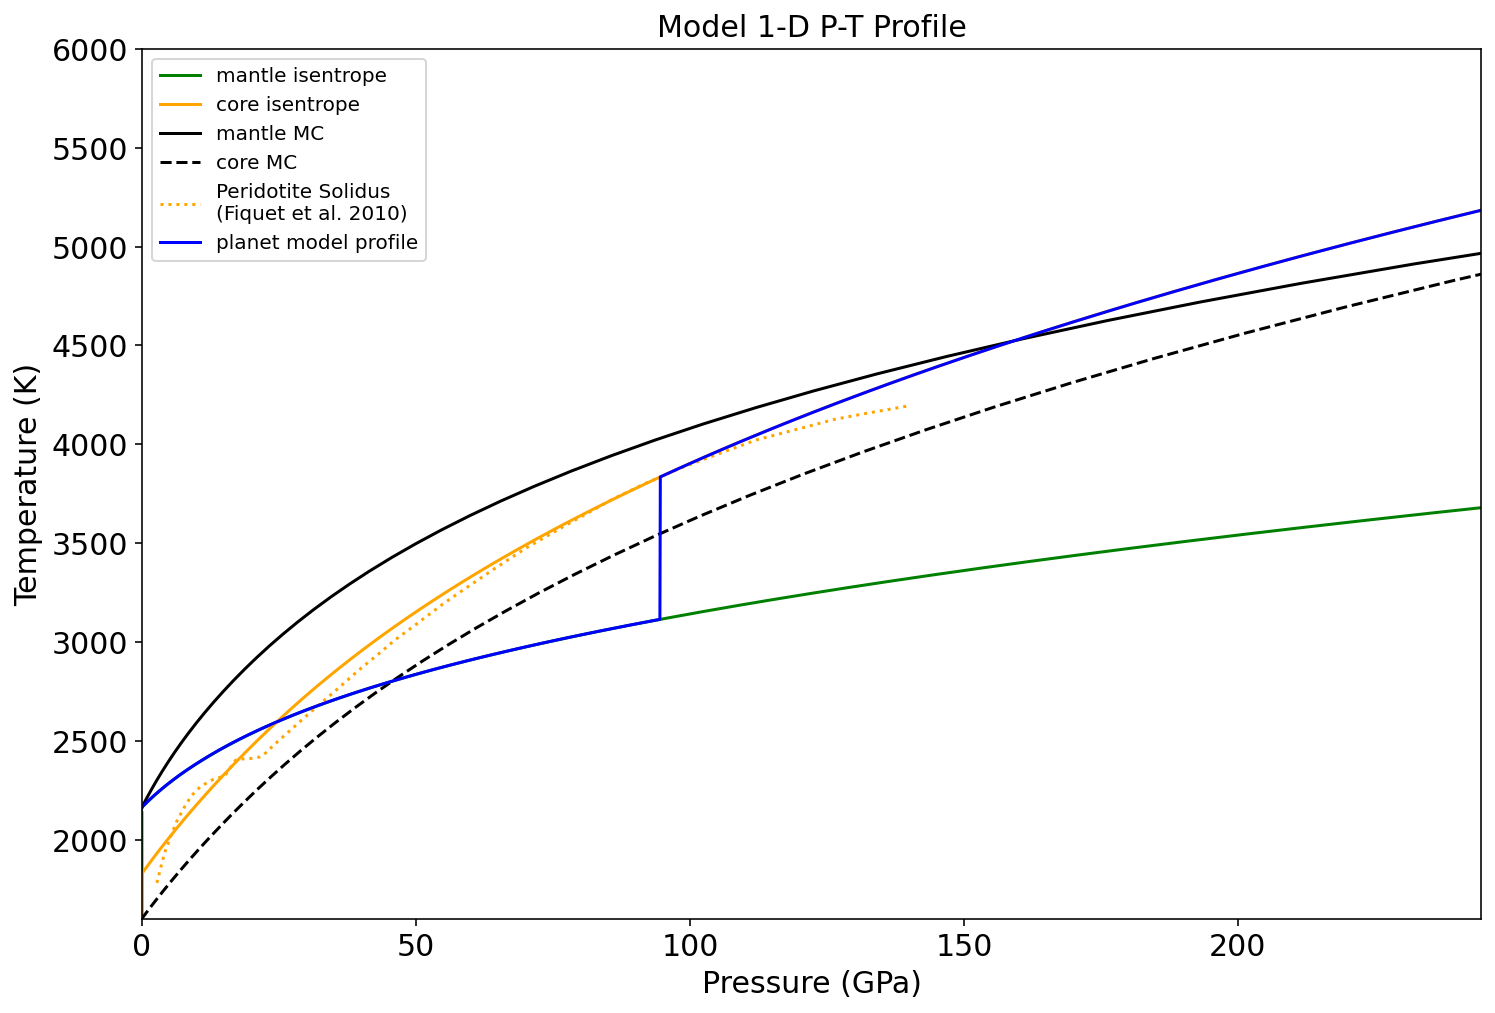

In [22]:
#filename='M0.1PyroSCmantleSMwarmN113_fulltension.txt'
#inplanet=planet_profile(file=filename)

def plot_PT_profile(planet,core,mantle,particleplanet=None,path=False,coreEOS='alloy',mantleEOS='pyrolite',showPREM=False):

    if coreEOS == 'iron':
        cEOS = IronEOS
    elif coreEOS == 'alloy':
        cEOS = AlloyEOS
    else:
        print('Unknown core EOS')
        return
    
    if mantleEOS == 'forsterite':
        mEOS = ForsteriteEOS
    elif mantleEOS == 'pyrolite':
        mEOS = PyroliteEOS
    else:
        print('Unknown mantle EOS')
        return
    
    sfont=15 # I like to set the size of my fonts

    # we just need 1 plot
    fig = plt.figure(figsize=(12,8))

    #plt.plot(PREM.pressure,PREM.temperature,'-',color='blue',label='Earth profile')
    plt.plot(mantle.pressure,mantle.temperature,'-',color='green',label='mantle isentrope',markersize=10)
    plt.plot(core.pressure,core.temperature,'-',color='orange',label='core isentrope',markersize=10)

    plt.plot(mEOS.mc.Pl,mEOS.mc.T,'-',color='black',label='mantle MC',markersize=10)
    plt.plot(cEOS.mc.Pl,cEOS.mc.T,'--',color='black',label='core MC',markersize=10)
    plt.plot(peridotitesolidusdatarr.iloc[:,0].values,peridotitesolidusdatarr.iloc[:,1].values,linestyle=':',color='orange',label='Peridotite Solidus\n(Fiquet et al. 2010)')
    plt.plot(planet.pressure[1:]/1.e10,planet.temperature[1:],'-',color='blue',label='planet model profile')


    #plt.ylim(0.,max(PREM.temperature))
    plt.ylim(1600.,6000)
    plt.xlim(0,max(planet.pressure[1:]/1.e10))
    plt.xlabel('Pressure (GPa)',size=sfont)
    plt.ylabel('Temperature (K)',size=sfont)
    plt.title('Model 1-D P-T Profile',size=sfont)
    plt.tick_params(labelsize=sfont)
    plt.legend(fontsize=sfont-5)

plot_PT_profile(planet,core,mantle,coreEOS='alloy',mantleEOS='pyrolite')

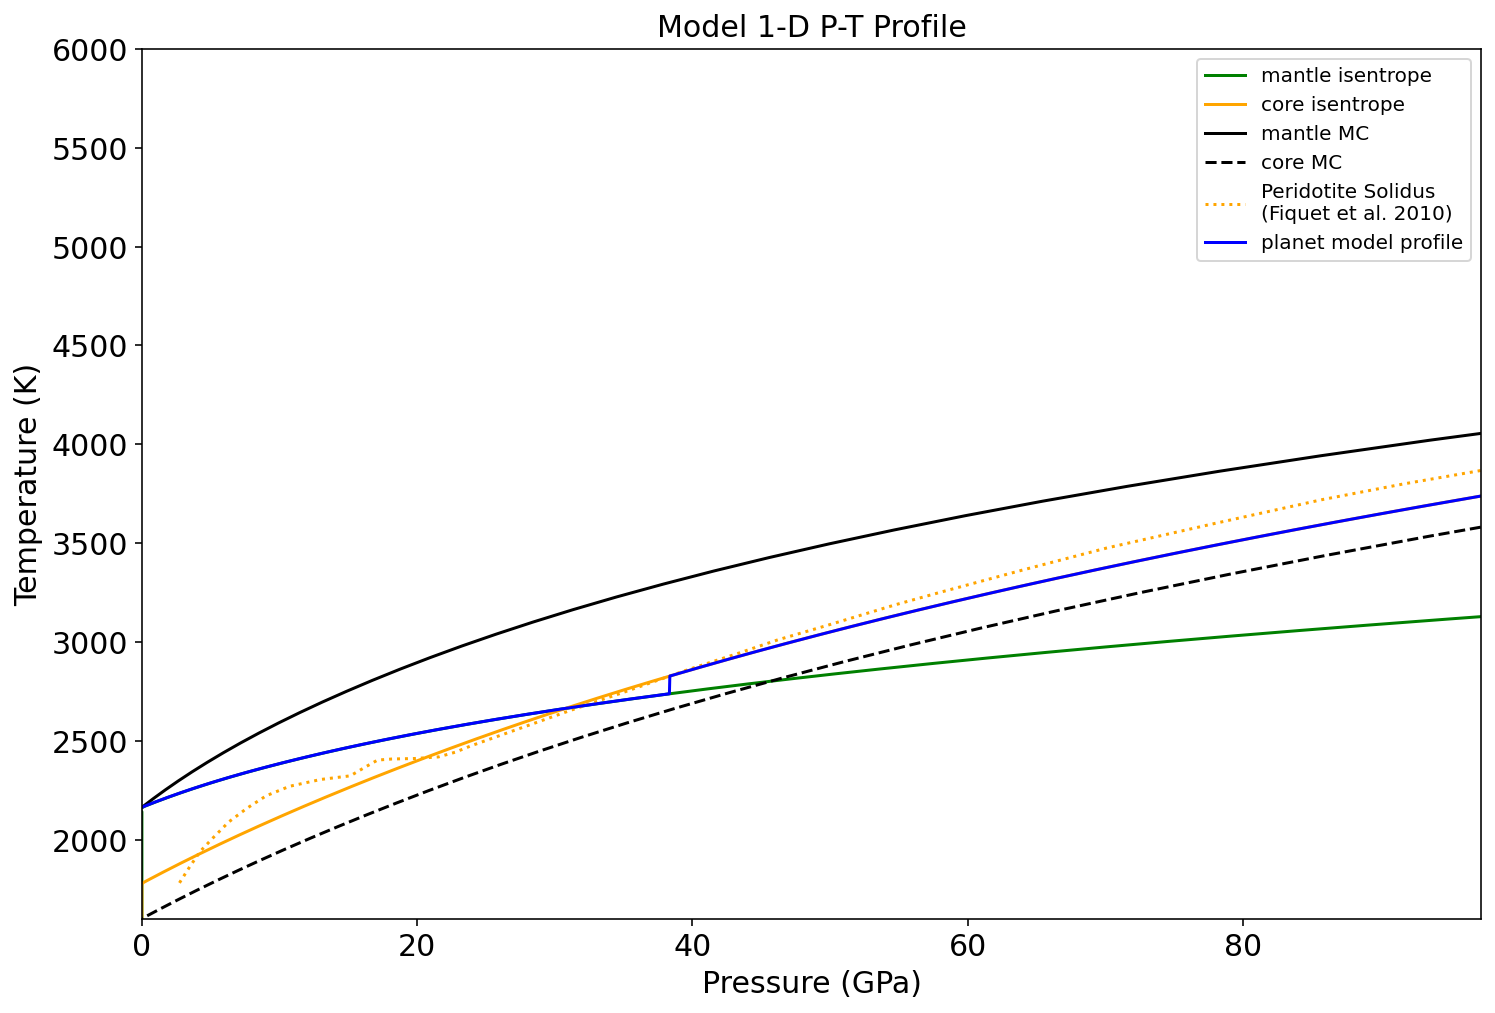

In [26]:
plot_PT_profile(projplanet,projcore,projmantle,coreEOS='alloy',mantleEOS='pyrolite')

92.65558287488125
(array([1700, 1701, 1702, ..., 3214, 3215, 3216], dtype=int64),)


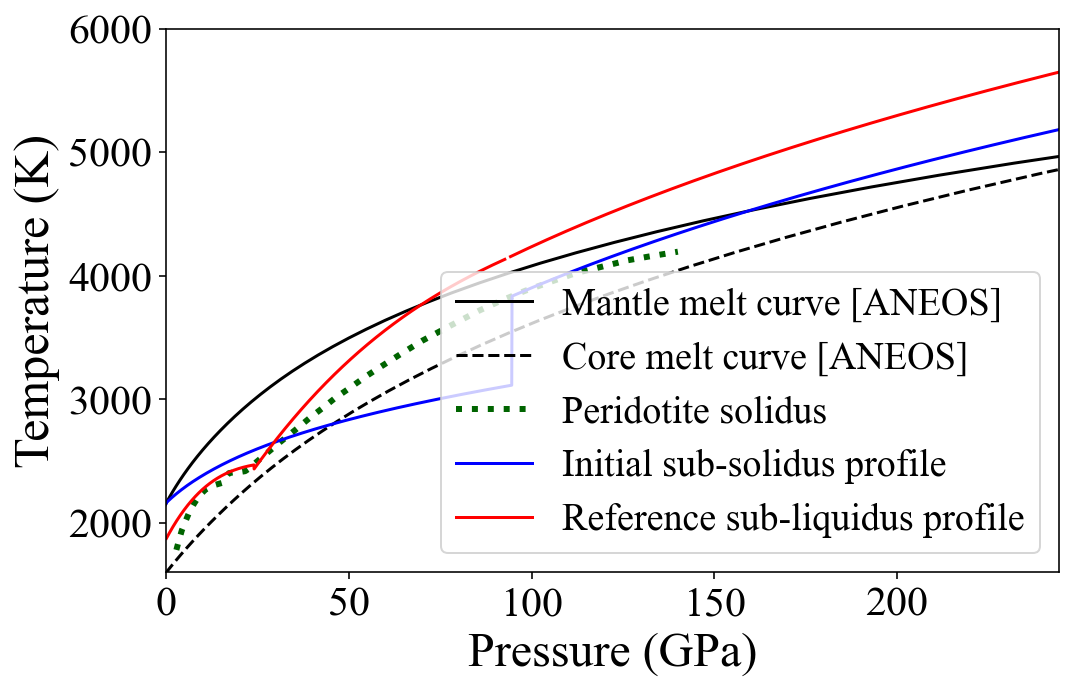

In [24]:
plt.rcParams["font.family"] = 'Times New Roman'
vT_rubie=np.vectorize(T_rubie,otypes=['float64'])
def plot_PT_Rubie_profile(planet,core,mantle,particleplanet=None,path=False,coreEOS='alloy',mantleEOS='pyrolite',showPREM=False,savefig=None):
    if coreEOS == 'iron':
        cEOS = IronEOS
    elif coreEOS == 'alloy':
        cEOS = AlloyEOS
    else:
        print('Unknown core EOS')
        return
    
    if mantleEOS == 'forsterite':
        mEOS = ForsteriteEOS
    elif mantleEOS == 'pyrolite':
        mEOS = PyroliteEOS
    else:
        print('Unknown mantle EOS')
        return
    
    sfont=15 # I like to set the size of my fonts

    # we just need 1 plot
    fig = plt.figure(figsize=(8,5))

    #plt.plot(PREM.pressure,PREM.temperature,'-',color='blue',label='Earth profile')
    #plt.plot(mantle.pressure,mantle.temperature,'-',color='green',label='mantle isentrope',markersize=10)
    #plt.plot(core.pressure,core.temperature,'-',color='orange',label='core isentrope',markersize=10)
    
    #plt.scatter(pres[indeq][indcore]/1.e9,tmp_T[indeq][indcore],s=2)
    #plt.scatter(pres[indeq][indmant]/1.e9,tmp_T[indeq][indmant],s=2)
    
    plt.plot(mEOS.mc.Pl,mEOS.mc.T,'-',color='black',label='Mantle melt curve [ANEOS]',markersize=10)
    plt.plot(cEOS.mc.Pl,cEOS.mc.T,'--',color='black',label='Core melt curve [ANEOS]',markersize=10)
    plt.plot(peridotitesolidusdatarr.iloc[:,0].values,peridotitesolidusdatarr.iloc[:,1].values,linestyle=':',color='darkgreen',label='Peridotite solidus',lw=3)#\n(Fiquet et al. 2010)
    plt.plot(planet.pressure[1:]/1.e10,planet.temperature[1:],'-',color='blue',label='Initial sub-solidus profile')
    PCMBrubie=P_rubie(CMB_rubie(planet.M/Mearth,planet.cf*planet.M/1.e3,(1-planet.cf)*planet.M/1.e3), 0, 0, planet.M/Mearth, planet.cf*planet.M/1.e3, (1-planet.cf)*planet.M/1.e3)
    print(PCMBrubie/1.e9)
    parry=np.array(planet.pressure[1:]/10.)
    idRubie=np.where(parry<PCMBrubie)
    print(idRubie)
    plt.plot(parry[idRubie]/1.e9,vT_rubie(parry[idRubie]),color='red',label='Reference sub-liquidus profile')
    SRubiecore = potentialT(PCMBrubie*10,T_rubie(PCMBrubie),cEOS)
    Rubiecore = isentrope_class(entropy=SRubiecore)
    for i in range(0,cEOS.ND):
        ind = np.where((cEOS.S[:,i] > 0))[0]
        interpfunction = interpolate.interp1d(cEOS.S[ind,i],cEOS.P[ind,i]) # MJ/K/kg, GPa
        Rubiecore.pressure = np.append(Rubiecore.pressure,interpfunction(SRubiecore/1.E3)) # GPa
        interpfunction = interpolate.interp1d(cEOS.S[ind,i],cEOS.T[ind]) # MJ/K/kg, K
        Rubiecore.temperature = np.append(Rubiecore.temperature,interpfunction(SRubiecore/1.E3)) # K
        interpfunction = interpolate.interp1d(cEOS.S[ind,i],cEOS.U[ind,i]) # MJ/K/kg, MJ/kg
        Rubiecore.energy = np.append(Rubiecore.energy,interpfunction(SRubiecore/1.E3)) # MJ/kg
    Rubiecore.density = cEOS.rho # g/cm3
    rubieParry=np.array(Rubiecore.pressure)
    rubieTarry=np.array(Rubiecore.temperature)
    plt.plot(Rubiecore.pressure[np.where(rubieParry>PCMBrubie/1.e9)],Rubiecore.temperature[np.where(rubieParry>PCMBrubie/1.e9)],color='red')
    #plt.plot(planet.pressure[1:]/1.e10,solvusfn(planet.pressure[1:]/10))


    sfont=24
    #plt.ylim(0.,max(PREM.temperature))
    plt.ylim(1600.,6000)
    plt.xlim(0,max(planet.pressure[1:]/1.e10))
    plt.xlabel('Pressure (GPa)',size=sfont)
    plt.ylabel('Temperature (K)',size=sfont+1)
    #plt.title('Model 1-D P-T Profile',size=sfont)
    plt.tick_params(labelsize=sfont-3)
    plt.legend(fontsize=sfont-5)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)

plot_PT_Rubie_profile(planet,core,mantle,coreEOS='alloy',mantleEOS='pyrolite',savefig='rubie_initial_profiles')

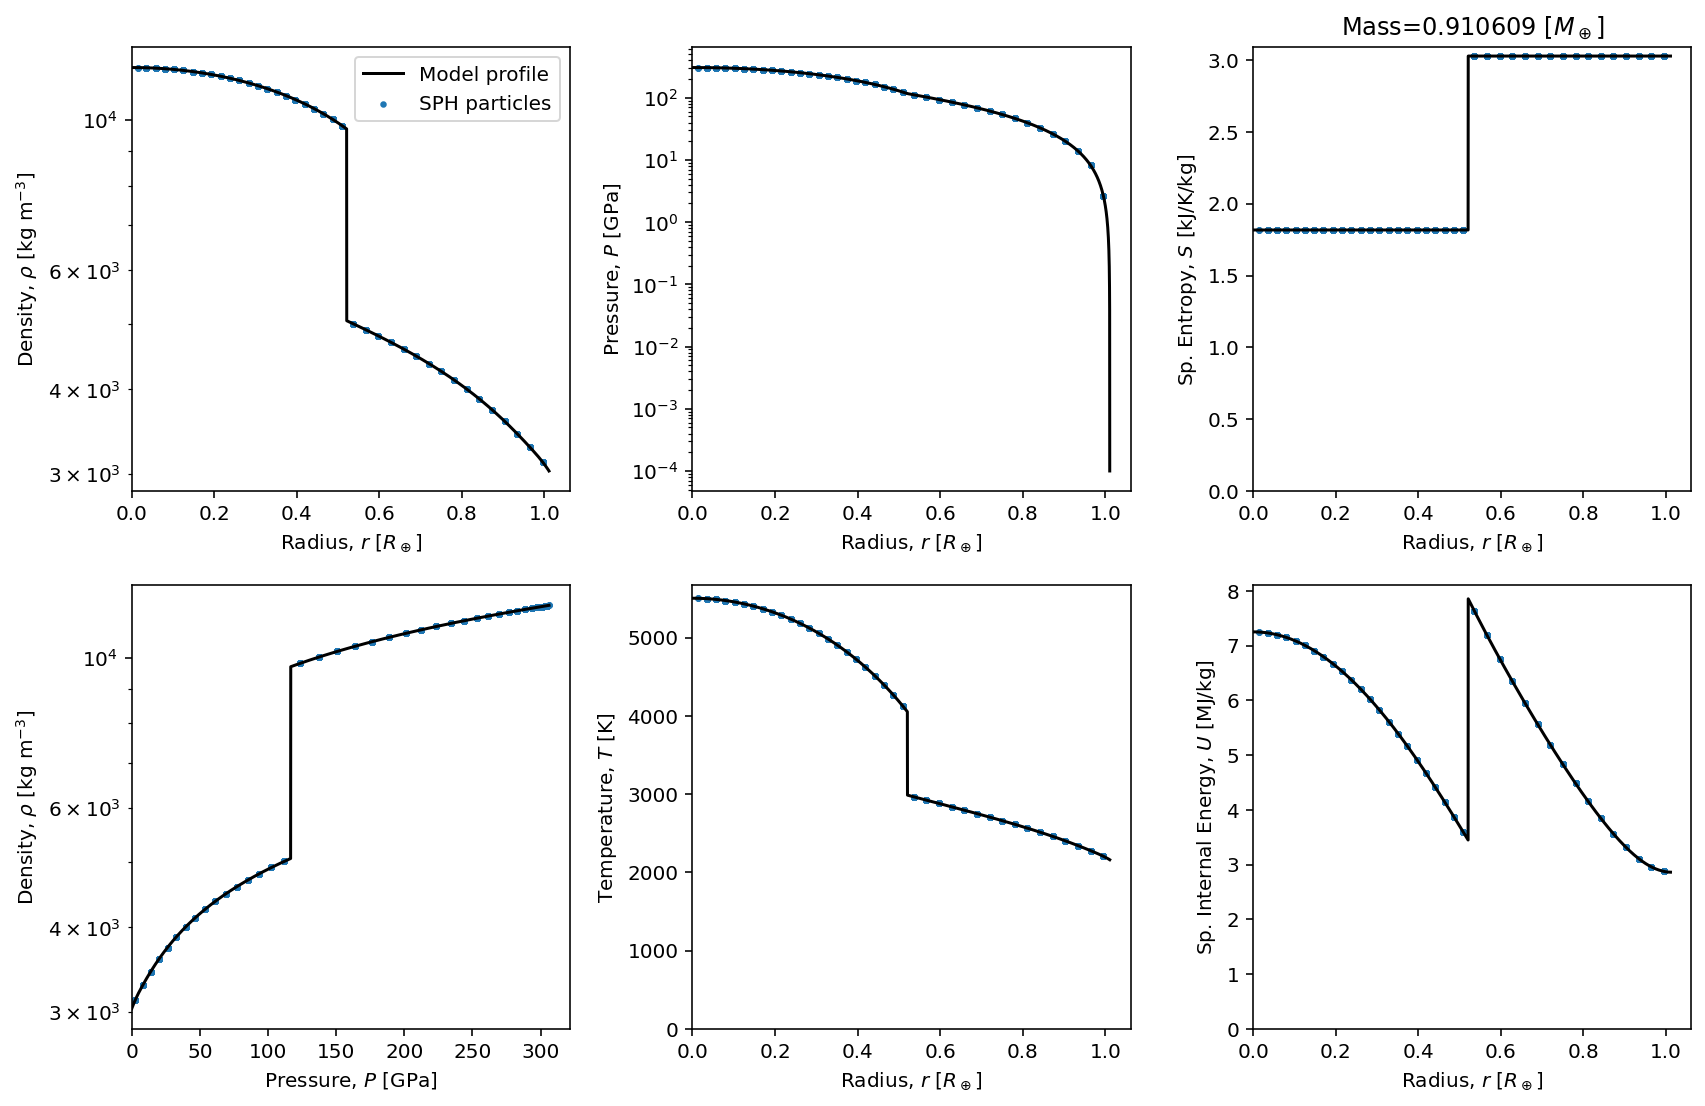

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


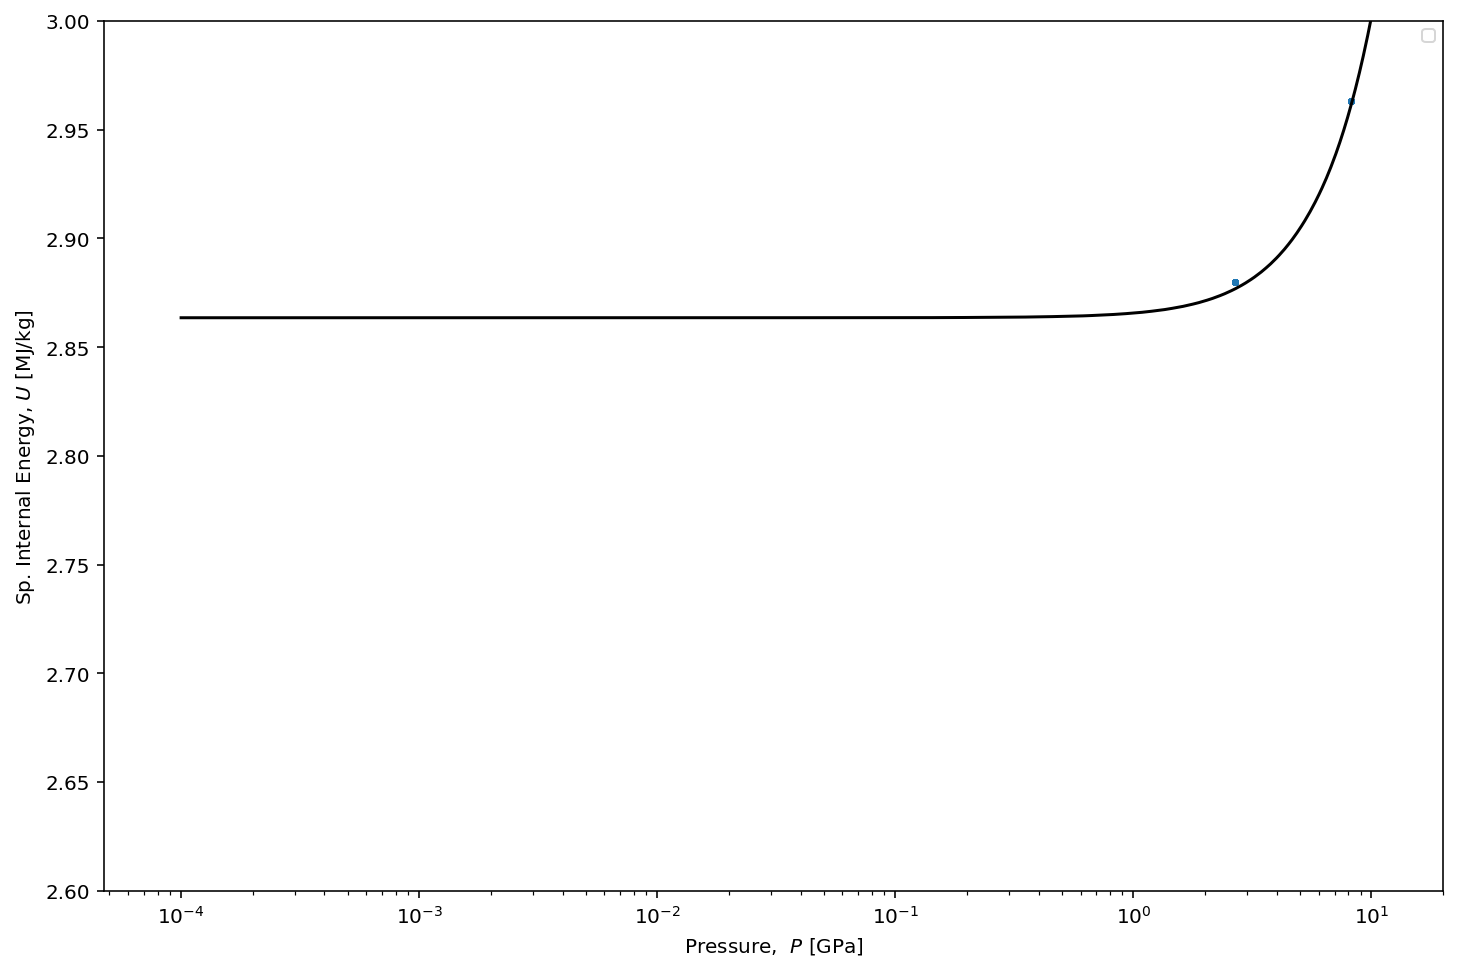

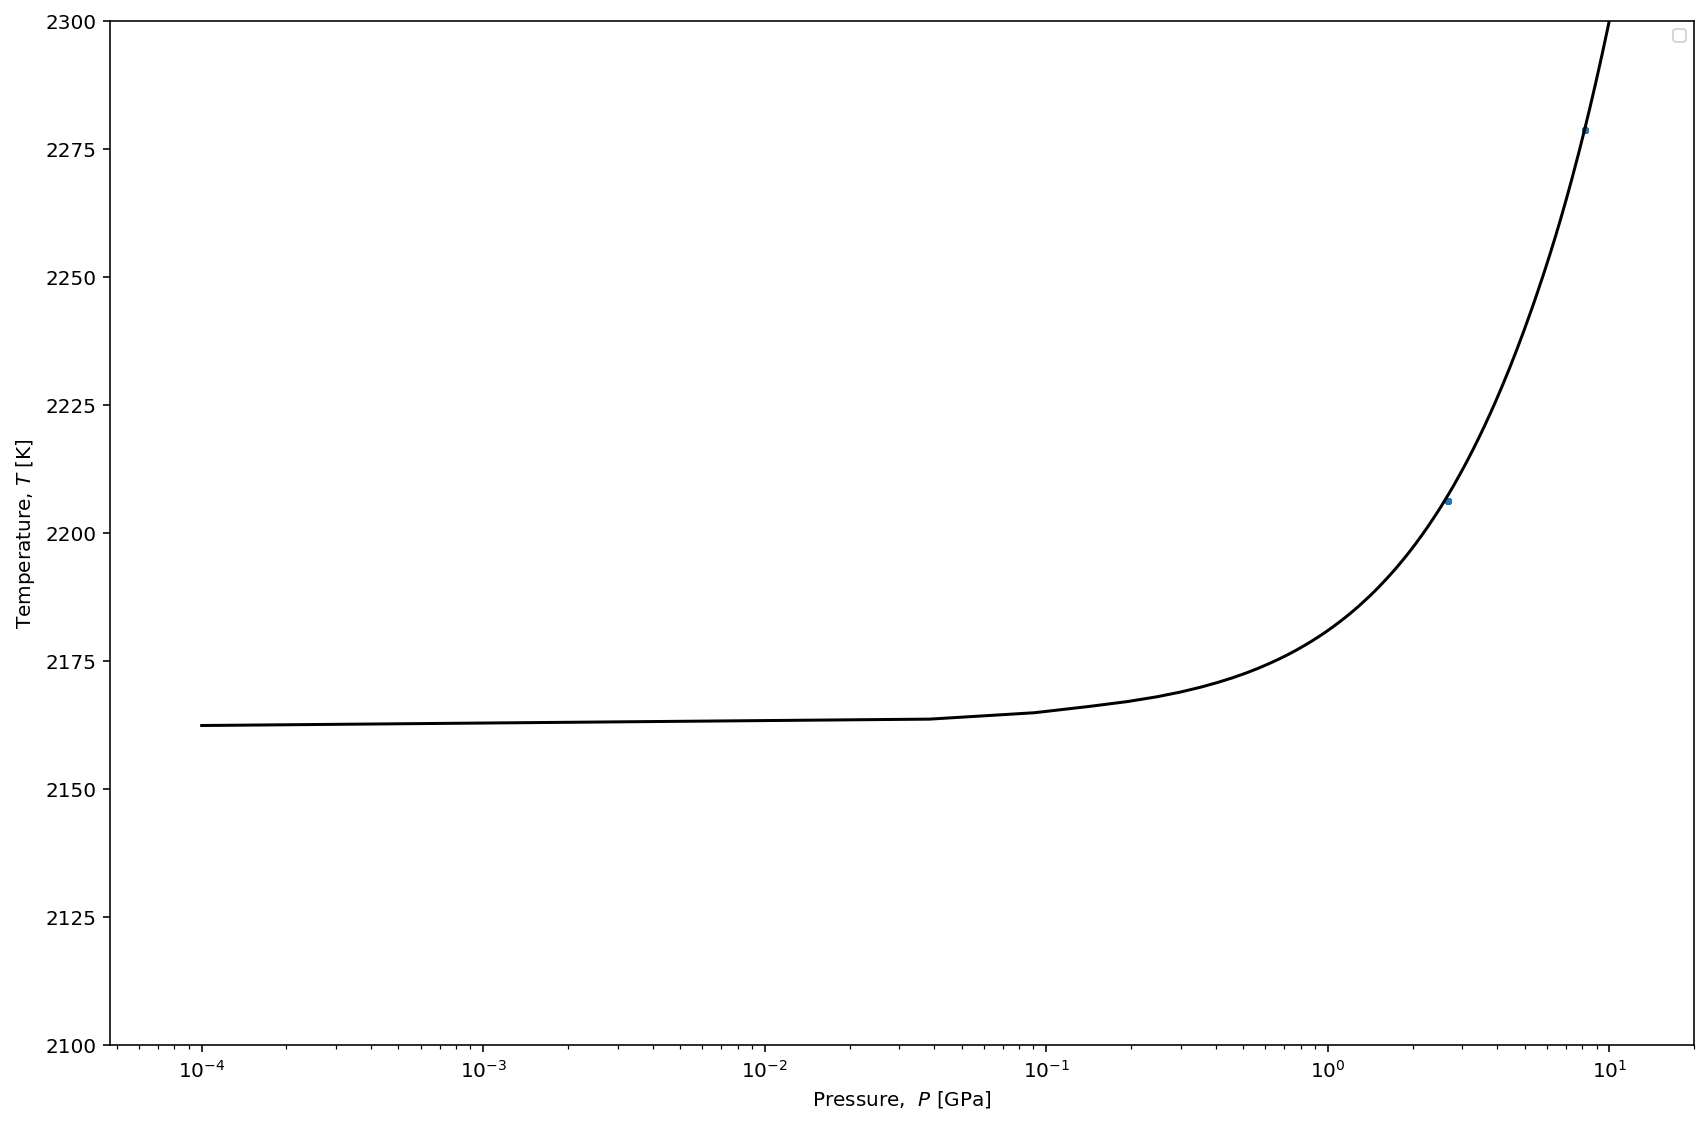

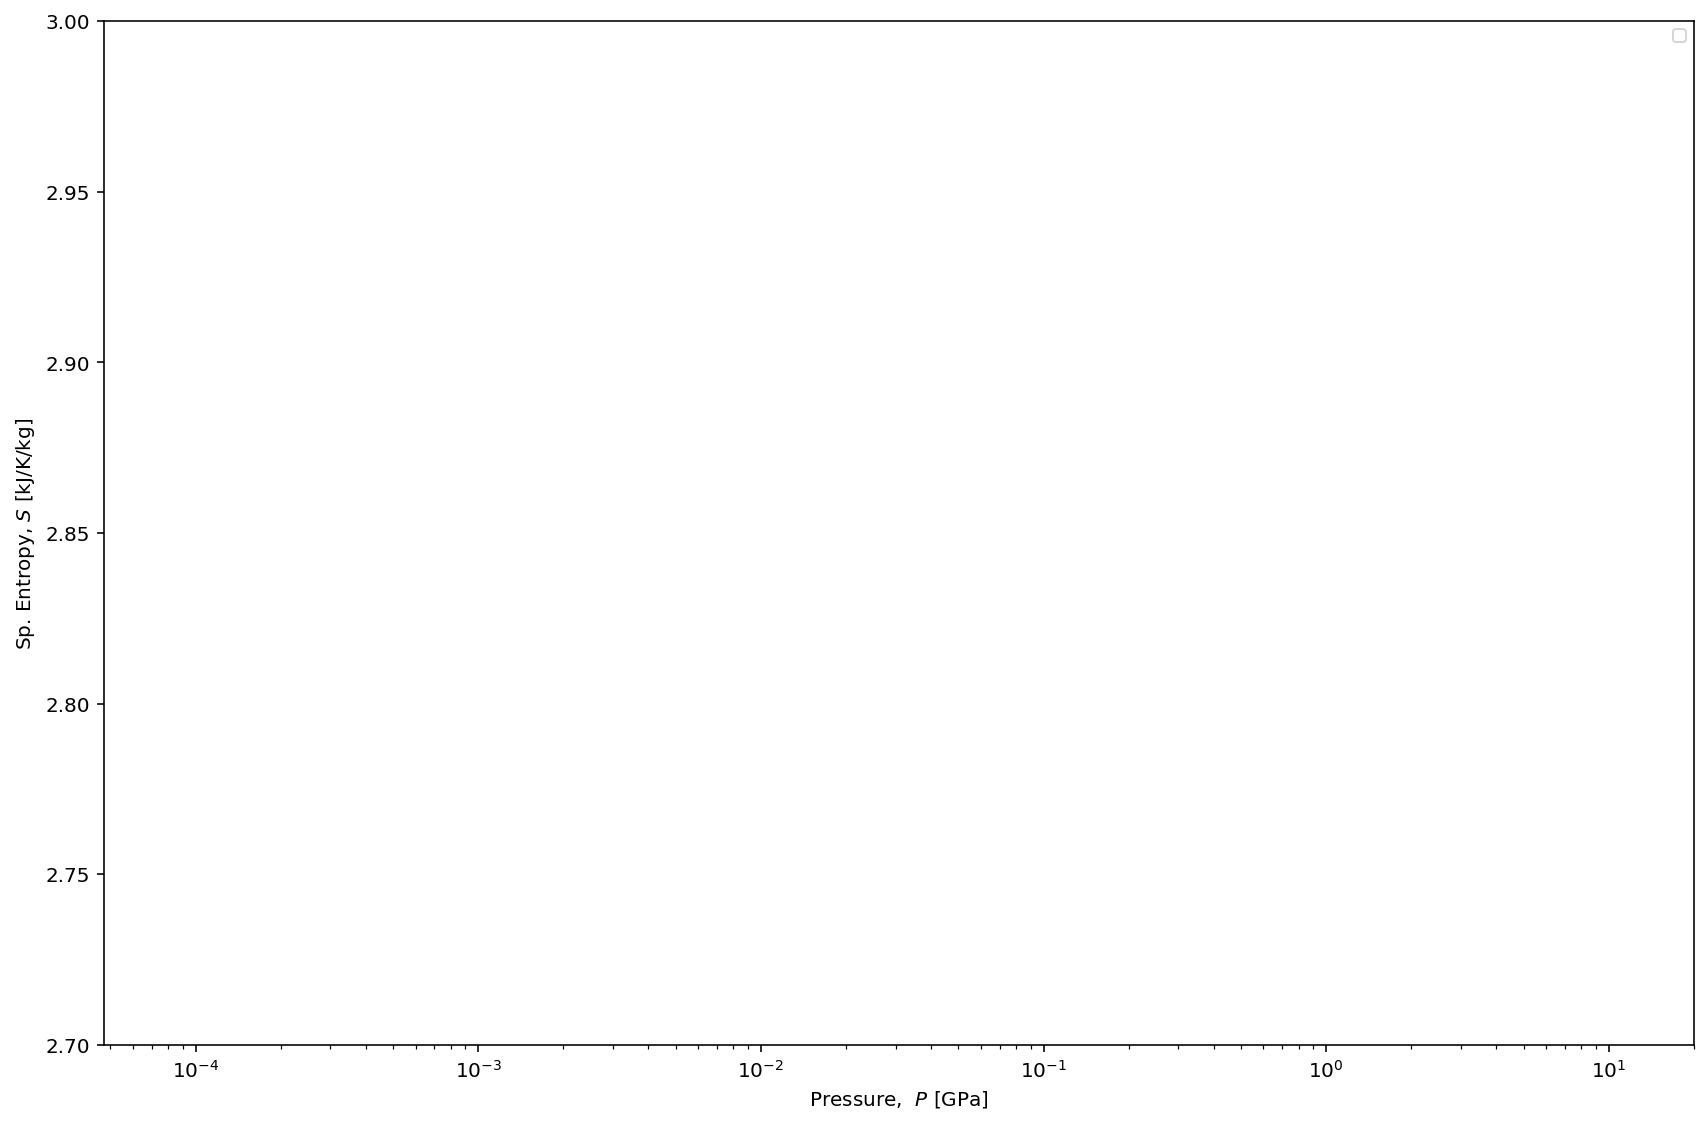

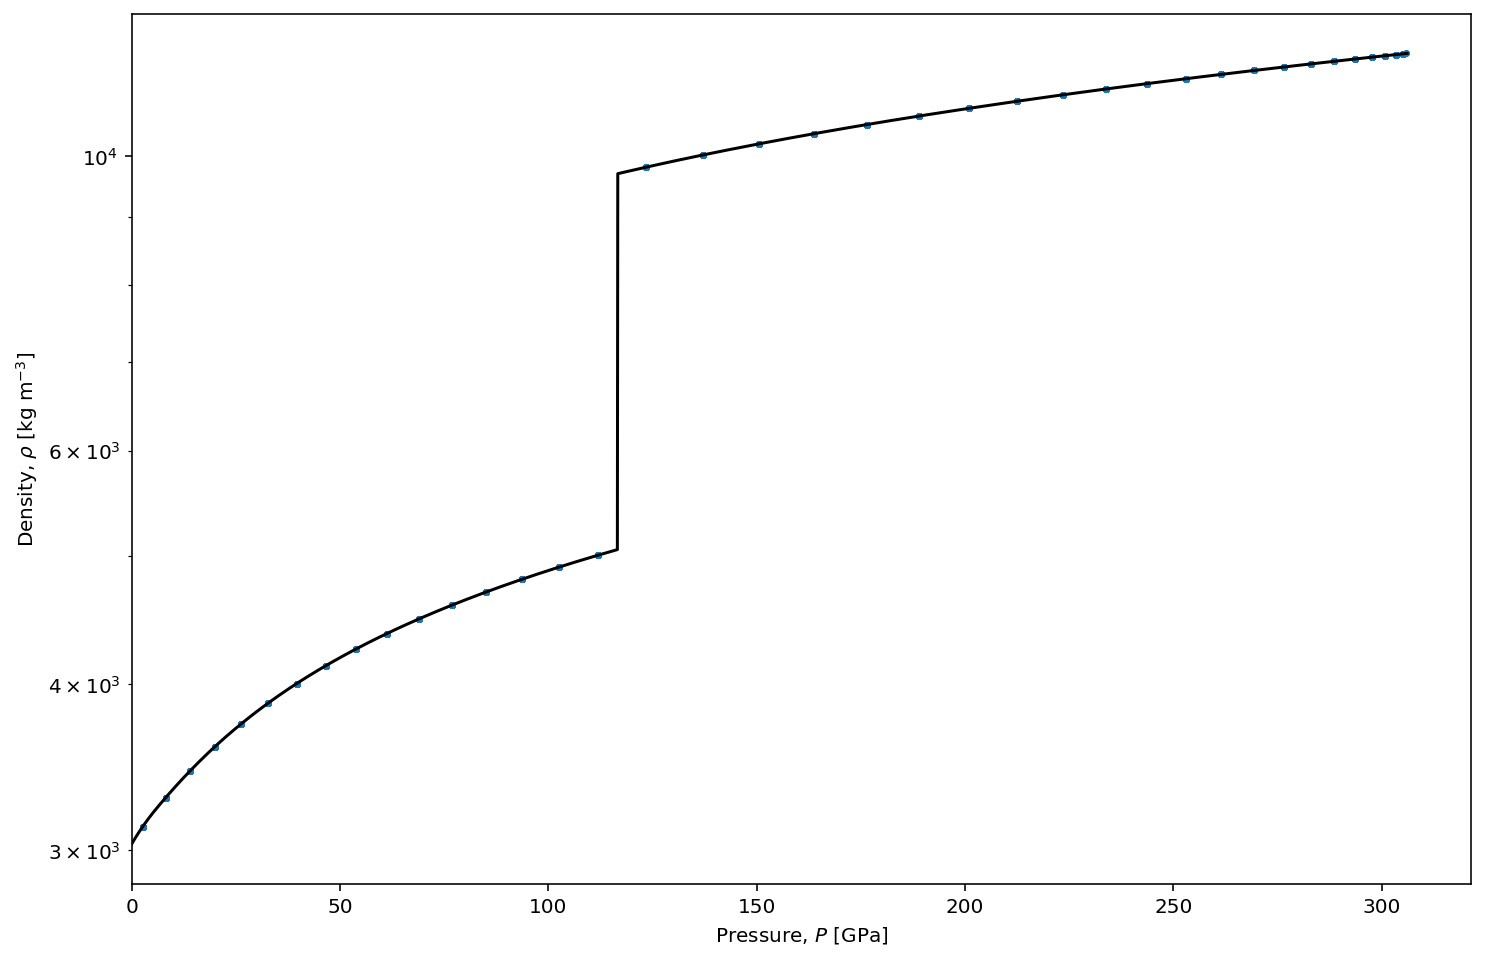

In [22]:
# plot a 1-D WoMa planet structure
def plot_spherical_profiles(planet,particleplanet,title=''):    
    fig, ax = plt.subplots(2, 3, figsize=(12,8))
    fig.suptitle(title,fontsize=12)
    rrr = np.sqrt(np.power(particleplanet.A2_pos[:,0]/Rearth,2)+np.power(particleplanet.A2_pos[:,1]/Rearth,2)+np.power(particleplanet.A2_pos[:,2]/Rearth,2))
    ax[0, 0].scatter(rrr, particleplanet.A1_rho/1.e-3,s=5,label='SPH particles')
    ax[0, 0].plot(planet.rarr / Rearth, planet.density/1.e-3,color='black',label='Model profile')
    ax[0, 0].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 0].set_ylabel(r"Density, $\rho$ [kg m$^{-3}$]")
    ax[0, 0].set_yscale("log")
    ax[0, 0].set_xlim(0, None)
    ax[0, 0].legend()
    
    ax[1, 0].scatter(particleplanet.A1_P/1.e10, particleplanet.A1_rho/1.e-3,s=5)
    ax[1, 0].plot(planet.pressure/1.e10, planet.density/1.e-3,color='black')
    ax[1, 0].set_xlabel(r"Pressure, $P$ [GPa]")
    ax[1, 0].set_ylabel(r"Density, $\rho$ [kg m$^{-3}$]")
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_xlim(0, None)
    ax[1, 0].set_ylim(0, None)
    
    ax[0, 1].scatter(rrr, particleplanet.A1_P/1.e10,s=5)
    ax[0, 1].plot(planet.rarr / Rearth, planet.pressure/1.e10,color='black')
    ax[0, 1].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 1].set_ylabel(r"Pressure, $P$ [GPa]")
    ax[0, 1].set_yscale("log")
    ax[0, 1].set_xlim(0, None)
    
    ax[1, 1].scatter(rrr, particleplanet.A1_T,s=5)
    ax[1, 1].plot(planet.rarr / Rearth, planet.temperature,color='black')
    ax[1, 1].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[1, 1].set_ylabel(r"Temperature, $T$ [K]")
    ax[1, 1].set_xlim(0, None)
    ax[1, 1].set_ylim(0, None)

    ax[1, 2].scatter(rrr, particleplanet.A1_u/1.e10,s=5)
    ax[1, 2].plot(planet.rarr / Rearth, planet.energy/1.e10,color='black')
    ax[1, 2].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[1, 2].set_ylabel(r"Sp. Internal Energy, $U$ [MJ/kg]")
    ax[1, 2].set_xlim(0, None)
    ax[1, 2].set_ylim(0, None)

    ax[0, 2].scatter(rrr, particleplanet.A1_s/1.e7,s=5)
    ax[0, 2].plot(planet.rarr / Rearth, planet.entropy/1.e7,color='black')
    ax[0, 2].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 2].set_ylabel(r"Sp. Entropy, $S$ [kJ/K/kg]")
    ax[0, 2].set_xlim(0, None)
    ax[0, 2].set_ylim(0, None)
    ax[0 ,2].set_title("Mass=%04f $[M_\oplus]$" % (np.amax(planet.M)/Mearth))

   
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.scatter(particleplanet.A1_P/1.e10, particleplanet.A1_u/1.e10,s=5)
    ax.plot(planet.pressure/1.e10, planet.energy/1.e10,color='black')
    #ax.plot(planet.pressure/1.E9, planet.energy/1.e6, label='Planet model',color='black')
    #ax.plot(mantleEOS.mc.Pl,mantleEOS.mc.Ul, label='Liquidus',color='blue')
    #ax.plot(mantleEOS.mc.Ps,mantleEOS.mc.Us, label='Solidus',color='red')
    ax.set_xlabel(r"Pressure,  $P$ [GPa]")
    ax.set_ylabel(r"Sp. Internal Energy, $U$ [MJ/kg]")
    ax.set_xscale("log")
    ax.set_xlim(None, 2.e1)
    ax.set_ylim(2.6, 3.0)
    ax.legend(fontsize=8)
    plt.tight_layout
    
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    ax.scatter(particleplanet.A1_P/1.e10, particleplanet.A1_T,s=5)
    ax.plot(planet.pressure/1.e10, planet.temperature,color='black')
    #ax.plot(mantleEOS.mc.Pl,mantleEOS.mc.T, label='Liquidus',color='blue')
    #ax.plot(mantleEOS.mc.Ps,mantleEOS.mc.T, label='Solidus',color='red')
    ax.set_xlabel(r"Pressure,  $P$ [GPa]")
    ax.set_ylabel(r"Temperature, $T$ [K]")
    ax.set_xscale('log')
    ax.set_xlim(None, 2.e1)
    ax.set_ylim(2100, 2300)
    ax.legend(fontsize=8)
   
    plt.tight_layout()
    
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    #ax.plot(planet.pressure/1.E9, planet.entropy/1.e3, label='Planet model',color='black')
    ax.scatter(particleplanet.A1_P/1.e10, particleplanet.A1_s/1.e7,s=5)
    ax.plot(planet.pressure/1.e10, planet.entropy/1.e7,color='black')
    #ax.plot(mantleEOS.mc.Pl,mantleEOS.mc.Sl*1.e3, label='Liquidus',color='blue')
    #ax.plot(mantleEOS.mc.Ps,mantleEOS.mc.Ss*1.e3, label='Solidus',color='red')
    ax.set_xlabel(r"Pressure,  $P$ [GPa]")
    ax.set_ylabel(r"Sp. Entropy, $S$ [kJ/K/kg]")
    ax.set_xscale("log")
    ax.set_xlim(None, 2.e1)
    ax.set_ylim(2.7, 3.0)
    ax.legend(fontsize=8)
    plt.tight_layout()
    
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    ax.scatter(particleplanet.A1_P/1.e10, particleplanet.A1_rho/1.e-3,s=5)
    ax.plot(planet.pressure/1.e10, planet.density/1.e-3,color='black')
    ax.set_xlabel(r"Pressure, $P$ [GPa]")
    ax.set_ylabel(r"Density, $\rho$ [kg m$^{-3}$]")
    ax.set_yscale('log')
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    
plot_spherical_profiles(planet,particleplanet)

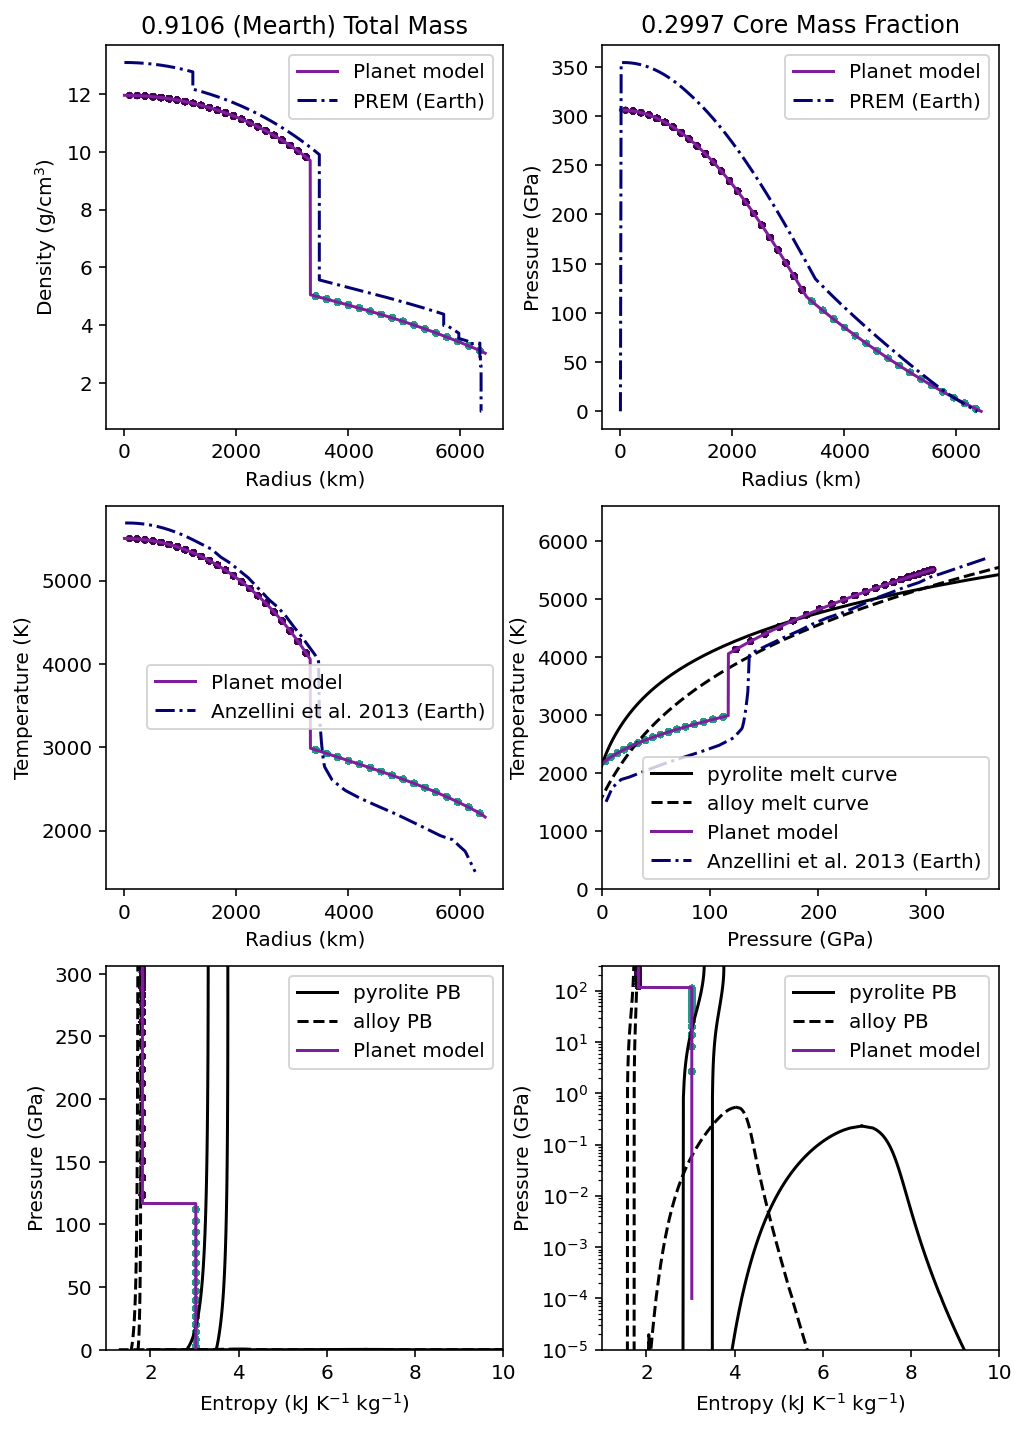

In [23]:
def plot_planet_prof(planet,particleplanet=None,show=False,path=False,coreEOS='iron',mantleEOS='forsterite'):
    inclpart = False
    if particleplanet:
        inclpart = True
    
    if planet.M >= 0.1*Mearth:
        showPREM = True
    else:
        showPREM = False

    if coreEOS == 'iron':
        cEOS = IronEOS
    elif coreEOS == 'alloy':
        cEOS = AlloyEOS
    else:
        print('Unknown core EOS')
        return
    
    if mantleEOS == 'forsterite':
        mEOS = ForsteriteEOS
    elif mantleEOS == 'pyrolite':
        mEOS = PyroliteEOS
    else:
        print('Unknown mantle EOS')
        return
        
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
    plt.subplots_adjust(wspace=0.25)
    #------------------------------
    ai=0
    aj=0
    axes[ai,aj].set_xlabel('Radius (km)')
    axes[ai,aj].set_ylabel('Density (g/cm$^3$)')
    if inclpart:
        axes[ai,aj].scatter(particleplanet.r/1e5,particleplanet.rho,s=6,c=particleplanet.A1_s/1e7,vmax=4.)
    axes[ai,aj].plot(planet.rarr/1.e5,planet.density,'-',color='xkcd:purple',label='Planet model')
    if showPREM:
        axes[ai,aj].plot(PREM.radius/1.e3,PREM.density/1.e3,'-.',color='xkcd:deep blue',label='PREM (Earth)')
    axes[ai,aj].set_title(str(planet.M/Mearth)[0:6]+" (Mearth) Total Mass")

    #------------------------------
    ai=0
    aj=1
    axes[ai,aj].set_xlabel('Radius (km)')
    axes[ai,aj].set_ylabel('Pressure (GPa)')

    if inclpart:
        axes[ai,aj].scatter(particleplanet.A1_r/1e5,particleplanet.A1_P/1e10,s=6,c=particleplanet.A1_s/1e7,vmax=4.)
    axes[ai,aj].plot(planet.rarr/1.e5,planet.pressure/1.e10,'-',color='xkcd:purple',label='Planet model')
    if showPREM:
        axes[ai,aj].plot(PREM.radius/1.e3,PREM.pressure,'-.',color='xkcd:deep blue',label='PREM (Earth)')
    axes[ai,aj].set_title(str(planet.cf)[0:6]+" Core Mass Fraction")

    #------------------------------
    ai=1
    aj=0
    axes[ai,aj].set_xlabel('Radius (km)')
    axes[ai,aj].set_ylabel('Temperature (K)')

    if inclpart:
        axes[ai,aj].scatter(particleplanet.A1_r/1e5,particleplanet.A1_T,s=6,c=particleplanet.A1_s/1e7,vmax=4.)
    axes[ai,aj].plot(planet.rarr/1.e5,planet.temperature,'-',color='xkcd:purple',label='Planet model')
    if showPREM:
        axes[ai,aj].plot(PREM.radius/1.e3,PREM.temperature,'-.',color='xkcd:deep blue',label='Anzellini et al. 2013 (Earth)')

    #------------------------------
    ai=1
    aj=1

    axes[ai,aj].set_xlabel('Pressure (GPa)')
    axes[ai,aj].set_ylabel('Temperature (K)')
    axes[ai,aj].plot(mEOS.mc.Pl,mEOS.mc.T,'-',color='black',label=mantleEOS+' melt curve',markersize=10)
    axes[ai,aj].plot(cEOS.mc.Pl,cEOS.mc.T,'--',color='black',label=coreEOS+' melt curve')

    if inclpart:
        axes[ai,aj].scatter(particleplanet.A1_P/1e10,particleplanet.A1_T,s=6,c=particleplanet.A1_s/1e7,vmax=4.)
    axes[ai,aj].plot(planet.pressure/1.e10,planet.temperature,'-',color='xkcd:purple',label='Planet model')
    if showPREM:
        axes[ai,aj].plot(PREM.pressure,PREM.temperature,'-.',color='xkcd:deep blue',label='Anzellini et al. 2013 (Earth)')


    axes[ai,aj].set_ylim(0,1.2*max(planet.temperature))
    axes[ai,aj].set_xlim(0,1.2*max(planet.pressure/1.e10))

    #------------------------------
    ai=2
    aj=0

    axes[ai,aj].set_ylabel('Pressure (GPa)')
    axes[ai,aj].set_xlabel('Entropy (kJ K$^{-1}$ kg$^{-1}$)')

    axes[ai,aj].plot(mEOS.mc.Sl*1e3,mEOS.mc.Pl,'-',color='black',label=mantleEOS+' PB')
    axes[ai,aj].plot(cEOS.mc.Sl*1e3,cEOS.mc.Pl,'--',color='black',label=coreEOS+' PB')
    axes[ai,aj].plot(mEOS.mc.Ss*1e3,mEOS.mc.Ps,'-',color='black',markersize=10)
    axes[ai,aj].plot(cEOS.mc.Ss*1e3,cEOS.mc.Ps,'--',color='black')

    axes[ai,aj].plot(mEOS.vc.Sl*1e3,mEOS.vc.Pl,'-',color='black',markersize=10)
    axes[ai,aj].plot(cEOS.vc.Sl*1e3,cEOS.vc.Pl,'--',color='black',markersize=10)
    axes[ai,aj].plot(mEOS.vc.Sv*1e3,mEOS.vc.Pv,'-',color='black',markersize=10) #label='forsterite VD'
    axes[ai,aj].plot(cEOS.vc.Sv*1e3,cEOS.vc.Pv,'--',color='black',markersize=10) #label='iron VD'

    if inclpart:
        axes[ai,aj].scatter(particleplanet.A1_s/1e7,particleplanet.P/1e10,s=6,c=particleplanet.A1_s/1e7,vmax=4.)
    axes[ai,aj].plot(planet.entropy/1e7,planet.pressure/1.e10,'-',color='xkcd:purple',label='Planet model')

    axes[ai,aj].set_xlim(1,10.)
    axes[ai,aj].set_ylim(0,max(planet.pressure/1.e10))

    #------------------------------
    ai=2
    aj=1

    axes[ai,aj].set_ylabel('Pressure (GPa)')
    axes[ai,aj].set_xlabel('Entropy (kJ K$^{-1}$ kg$^{-1}$)')

    axes[ai,aj].plot(mEOS.mc.Sl*1e3,mEOS.mc.Pl,'-',color='black',label=mantleEOS+' PB')
    axes[ai,aj].plot(mEOS.mc.Ss*1e3,mEOS.mc.Ps,'-',color='black',markersize=10)
    axes[ai,aj].plot(cEOS.mc.Sl*1e3,cEOS.mc.Pl,'--',color='black',label=coreEOS+' PB')
    axes[ai,aj].plot(cEOS.mc.Ss*1e3,cEOS.mc.Ps,'--',color='black')

    axes[ai,aj].plot(mEOS.vc.Sl*1e3,mEOS.vc.Pl,'-',color='black',markersize=10)
    axes[ai,aj].plot(cEOS.vc.Sl*1e3,cEOS.vc.Pl,'--',color='black',markersize=10)
    axes[ai,aj].plot(mEOS.vc.Sv*1e3,mEOS.vc.Pv,'-',color='black',markersize=10) #label='forsterite VD'
    axes[ai,aj].plot(cEOS.vc.Sv*1e3,cEOS.vc.Pv,'--',color='black',markersize=10) #label='iron VD'

    if inclpart:
        axes[ai,aj].scatter(particleplanet.A1_s/1e7,particleplanet.P/1e10,s=6,c=particleplanet.A1_s/1e7,vmax=4.)
    axes[ai,aj].plot(planet.entropy/1e7,planet.pressure/1.e10,'-',color='xkcd:purple',label='Planet model')

    axes[ai,aj].set_xlim(1,10.)
    axes[ai,aj].set_ylim(1e-5,max(planet.pressure/1.e10))
    axes[ai,aj].semilogy()

    # don't show a plot in lower right
    #axes[2,1].axis("off")

    axes[0,0].legend()
    axes[0,1].legend()
    axes[1,0].legend()
    axes[1,1].legend()
    axes[2,0].legend()
    axes[2,1].legend()

    # this saves a pdf file -- vector graphics are preferred
    if path:
        plt.savefig(path, format='pdf', dpi=300, transparent=True)

    if show:
        plt.show()
        
plot_planet_prof(planet,particleplanet=particleplanet,show=True,path=False,coreEOS='alloy',mantleEOS='pyrolite') #path=os.path.expanduser('~')+'/Documents/testinitprof.pdf'

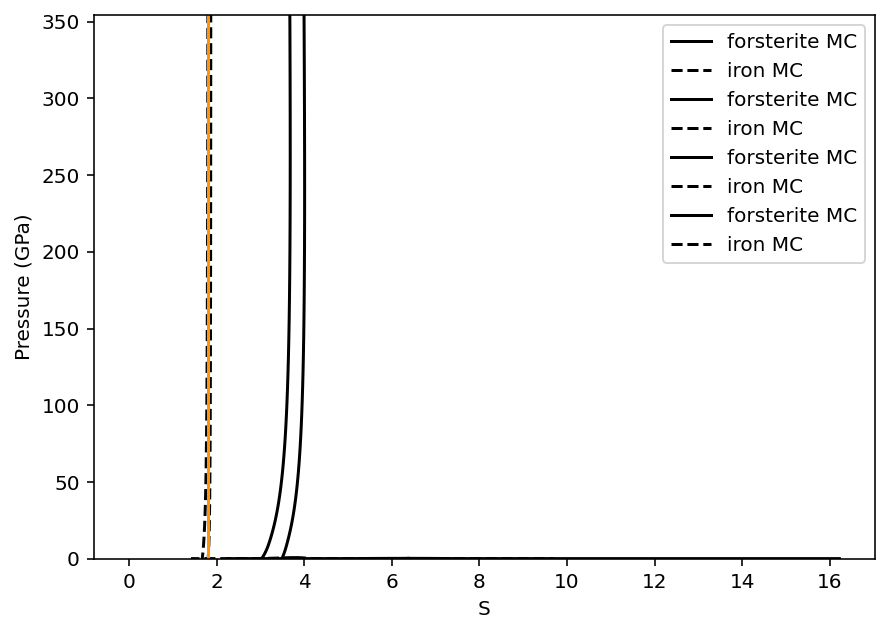

In [24]:
fig = plt.figure(figsize=(7,5))

#plt.plot(PREM.pressure,PREM.temperature,'-.',color='xkcd:deep blue',label='PREM profile')
#plt.plot(mantle.pressure,mantle.temperature,'-',color='xkcd:purple',label='mantle isentrope',markersize=10)
#plt.plot(core.pressure,core.temperature,'-',color='xkcd:tangerine',label='core isentrope',markersize=10)

plt.plot(ForsteriteEOS.mc.Sl*1e3,ForsteriteEOS.mc.Pl,'-',color='black',label='forsterite MC',markersize=10)
plt.plot(IronEOS.mc.Sl*1e3,IronEOS.mc.Pl,'--',color='black',label='iron MC',markersize=10)
plt.plot(ForsteriteEOS.mc.Ss*1e3,ForsteriteEOS.mc.Ps,'-',color='black',label='forsterite MC',markersize=10)
plt.plot(IronEOS.mc.Ss*1e3,IronEOS.mc.Ps,'--',color='black',label='iron MC',markersize=10)

plt.plot(ForsteriteEOS.vc.Sl*1e3,ForsteriteEOS.vc.Pl,'-',color='black',label='forsterite MC',markersize=10)
plt.plot(IronEOS.vc.Sl*1e3,IronEOS.vc.Pl,'--',color='black',label='iron MC',markersize=10)
plt.plot(ForsteriteEOS.vc.Sv*1e3,ForsteriteEOS.vc.Pv,'-',color='black',label='forsterite MC',markersize=10)
plt.plot(IronEOS.vc.Sv*1e3,IronEOS.vc.Pv,'--',color='black',label='iron MC',markersize=10)

plt.axvline(1.81,color='xkcd:tangerine')

#plt.ylim(0.,max(PREM.temperature))
plt.ylim(0,max(PREM.pressure))
#plt.semilogy()
plt.ylabel('Pressure (GPa)')
plt.xlabel('S')
plt.legend()
plt.show()


In [31]:
R = 8.3144598 #J/mol/K, gas constant
Tgas = 500 #K
Plo = 100 #Pa, 1 millibar
Phi = 1000 #Pa, 10 millibar
Vmollo = R*Tgas/Plo
Vmolhi = R*Tgas/Phi
mmH2 = 2*1.00784e-3
rholo = mmH2/Vmollo
rhohi = mmH2/Vmolhi
print(rholo*1e-3,rhohi*1e-3, 'g/cm^3')

4.848613255668156e-08 4.848613255668156e-07 g/cm^3
